## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
%matplotlib inline

# Camera Calibration

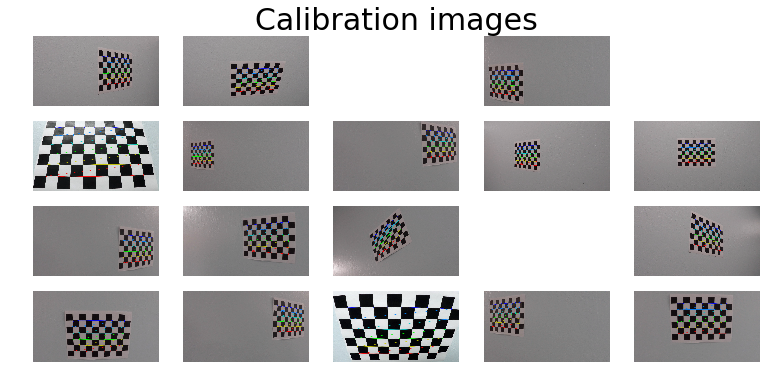

In [2]:
### Extract object points and image points for camera calibration.  

# No. of corners for calibration
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Plot calibration images with corners
fig = plt.figure(figsize=(13, 6))
plt.title('Calibration images', fontsize=30)
plt.axis('off')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        
        fig.add_subplot(4, 5, idx+1)
        plt.axis('off')
        plt.imshow(img, cmap='gray')

In [3]:
# Load image for camera calibration
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Calibrate camera with objpoints and imgpoints
# Calculate the camera matrix (mtx) and distortion coefficients (dist)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Image Distortion

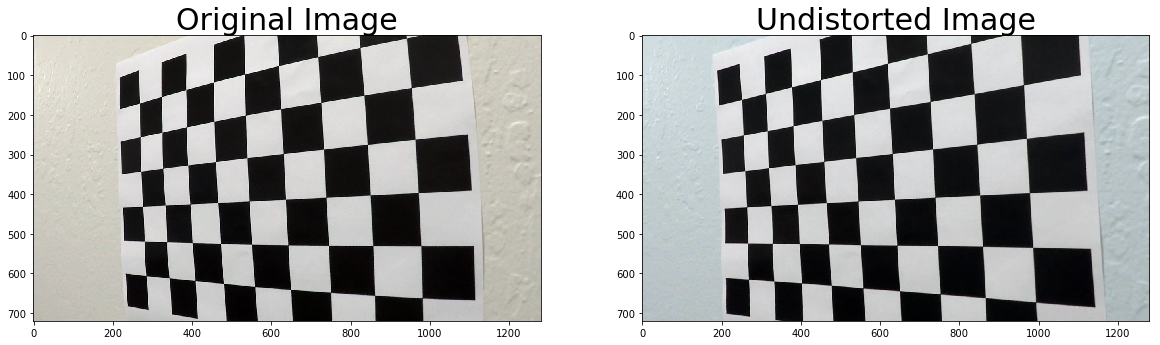

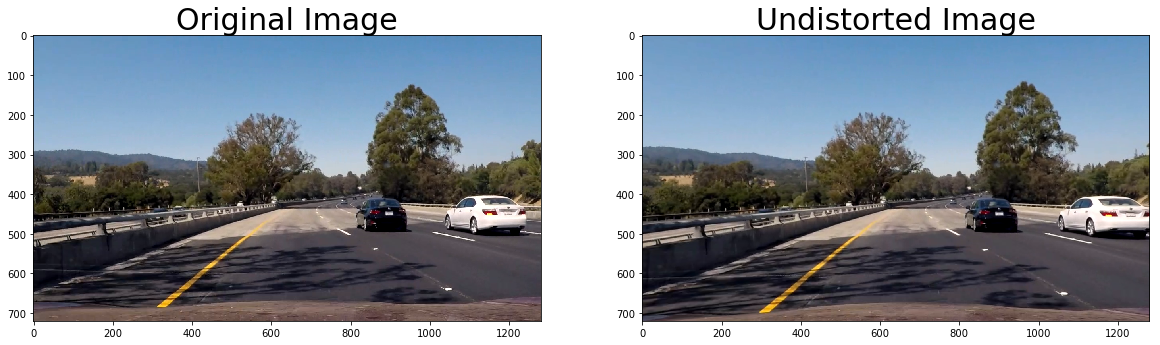

In [4]:
def undistort_image(image):
    """
    Purpose: Takes in a RGB image and returns the undistorted image
    """
    return cv2.undistort(image, mtx, dist, None, mtx)

# Define a test image to use to display image transforms
test_image = cv2.imread('./test_images/test7.png')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_undist = undistort_image(test_image)

img = cv2.imread('camera_cal/calibration4.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(rgb)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort_image(img))
ax2.set_title('Undistorted Image', fontsize=30)
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
ax3.imshow(test_image)
ax3.set_title('Original Image', fontsize=30)
ax4.imshow(test_undist)
ax4.set_title('Undistorted Image', fontsize=30)

# Gradient Thresholded Binaries

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Purpose: To calculate the gradient/derivative of an image in the x or y direction
             and return the binary thresholded Sobel image
    """

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the gradient and it's absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Calculate the binary sobel
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_sobel


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Purpose: To calculate the magnitude of the gradient of an image in the x or y direction
             and return the binary thresholded Sobel image
    """
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the gradient of x and y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Calculate the magnitude
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * mag_sobel / np.max(mag_sobel))

    # Create a binary mask where magnitude thresholds are met
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return binary_sobel


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Purpose: To calculate the direction of the gradient of an image in the x or y direction
             and return the binary thresholded Sobel image
    """
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the gradient and it's absolute value
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # Calculate the direction of the gradient
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)

    # Create a binary mask where direction thresholds are met
    binary_sobel = np.zeros_like(abs_sobelx)
    binary_sobel[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

    return binary_sobel

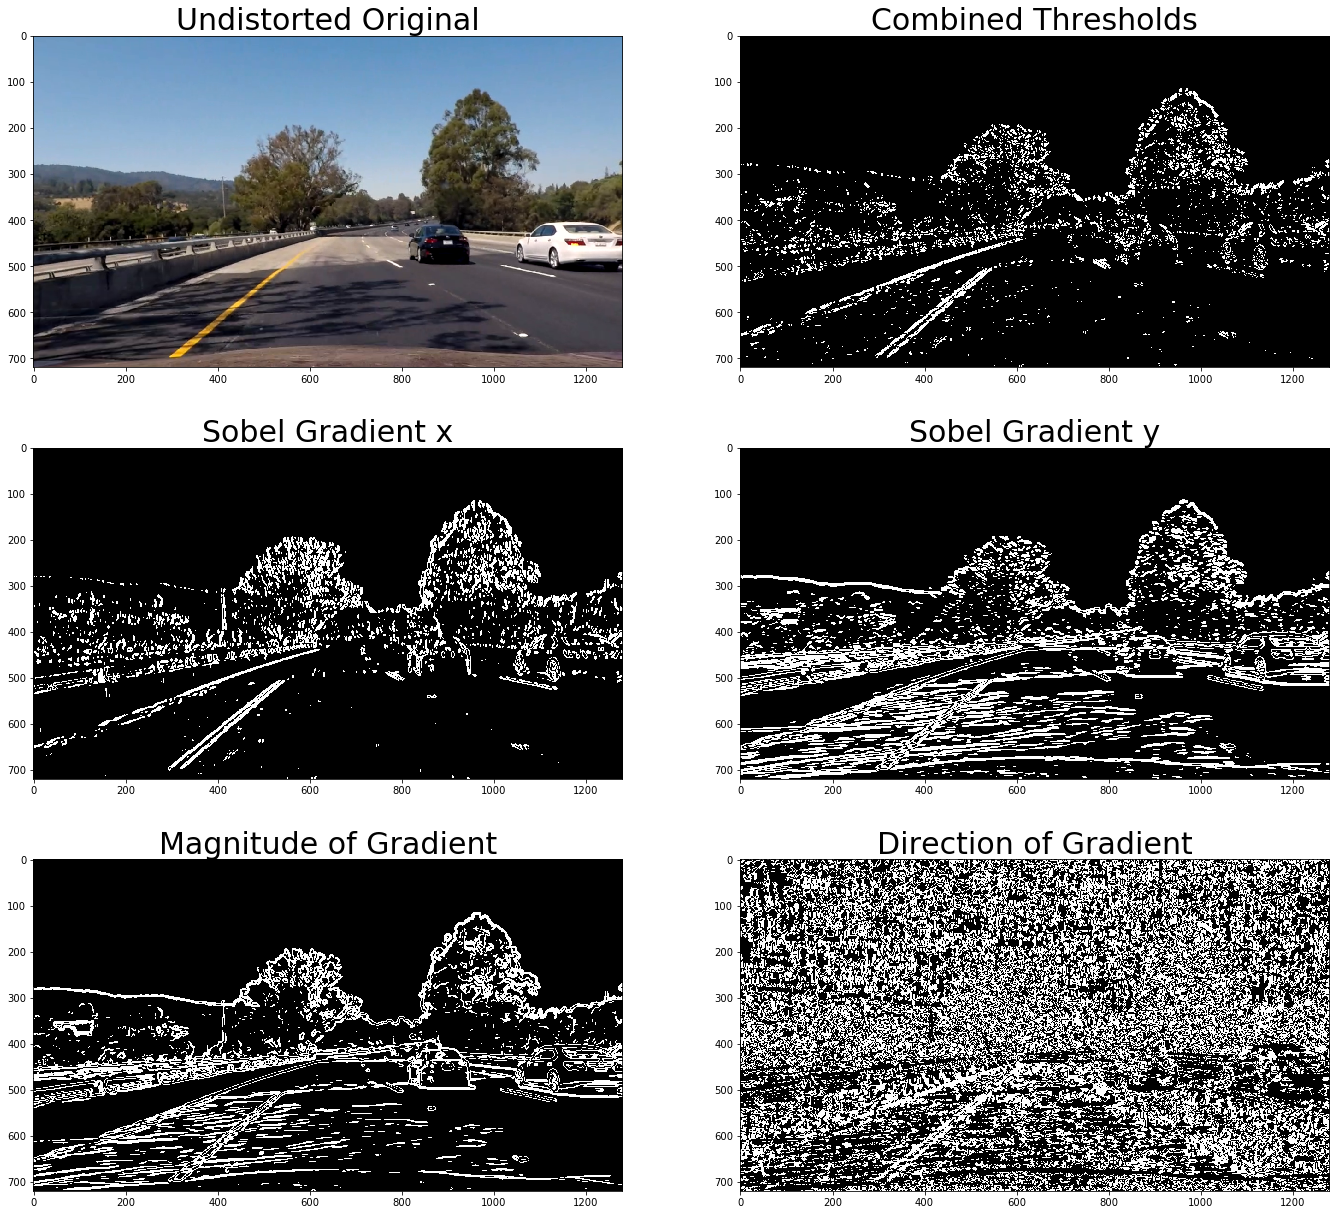

In [6]:
# Choose a Sobel kernel size (odd number)
# A larger number respresents smoother gradient measurements
ksize = 15

# Apply each of the thresholding functions
sxbinary = abs_sobel_thresh(test_undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))
sybinary = abs_sobel_thresh(test_undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(test_undist, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(test_undist, sobel_kernel=ksize, thresh=(0.5, 1.3))

# Combine the thresholds to extract the lane lines
combined = np.zeros_like(dir_binary)
combined[((sxbinary == 1) & (sybinary == 1)) | ((mag_binary == 1) & (dir_binary == 1))
         | ((sxbinary == 1) & (dir_binary == 1))] = 1

# Visualize the results
fig = plt.figure(figsize=(18, 9))

img_list = [[test_undist, 'Undistorted Original'],
            [combined, 'Combined Thresholds'],
            [sxbinary, 'Sobel Gradient x'],
            [sybinary, 'Sobel Gradient y'],
            [mag_binary, 'Magnitude of Gradient'],
            [dir_binary, 'Direction of Gradient']]

rows = 3
cols = 2

for i in range(len(img_list)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(img_list[i][0], cmap='gray')
    ax.set_title(img_list[i][1], fontsize=30)

plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)

# Color Thresholded Binaries

In [7]:
def R_channel(image, threshold):
    """
    Purpose: To extract the red channel of an image and return the binary thresholded image
    """
    R = image[:,:,0]
    R_binary = np.zeros_like(R)
    R_binary[(R > threshold[0]) & (R <= threshold[1])] = 1
    
    return R_binary


def H_channel(image, threshold):
    """
    Purpose: To extract the Hue channel of an image and return the binary thresholded image
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    H = hls[:,:,0]
    H_binary = np.zeros_like(H)
    H_binary[(H > threshold[0]) & (H <= threshold[1])] = 1

    return H_binary


def S_channel(image, threshold):
    """
    Purpose: To extract the HLS Saturation channel of an image and return the binary thresholded image
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    S = hls[:,:,2]
    S_binary = np.zeros_like(S)
    S_binary[(S > threshold[0]) & (S <= threshold[1])] = 1

    return S_binary

def S2_channel(image, threshold):
    """
    Purpose: To extract the HSV Saturation channel of an image and return the binary thresholded image
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)
    S2 = hsv[:,:,1]
    S2_binary = np.zeros_like(S2)
    S2_binary[(S2 > threshold[0]) & (S2 <= threshold[1])] = 1

    return S2_binary

def L_channel(image, threshold):
    """
    Purpose: To extract the Saturation channel of an image and return the binary thresholded image
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    L = hls[:,:,1]
    L_binary = np.zeros_like(L)
    L_binary[(L > threshold[0]) & (L <= threshold[1])] = 1

    return L_binary

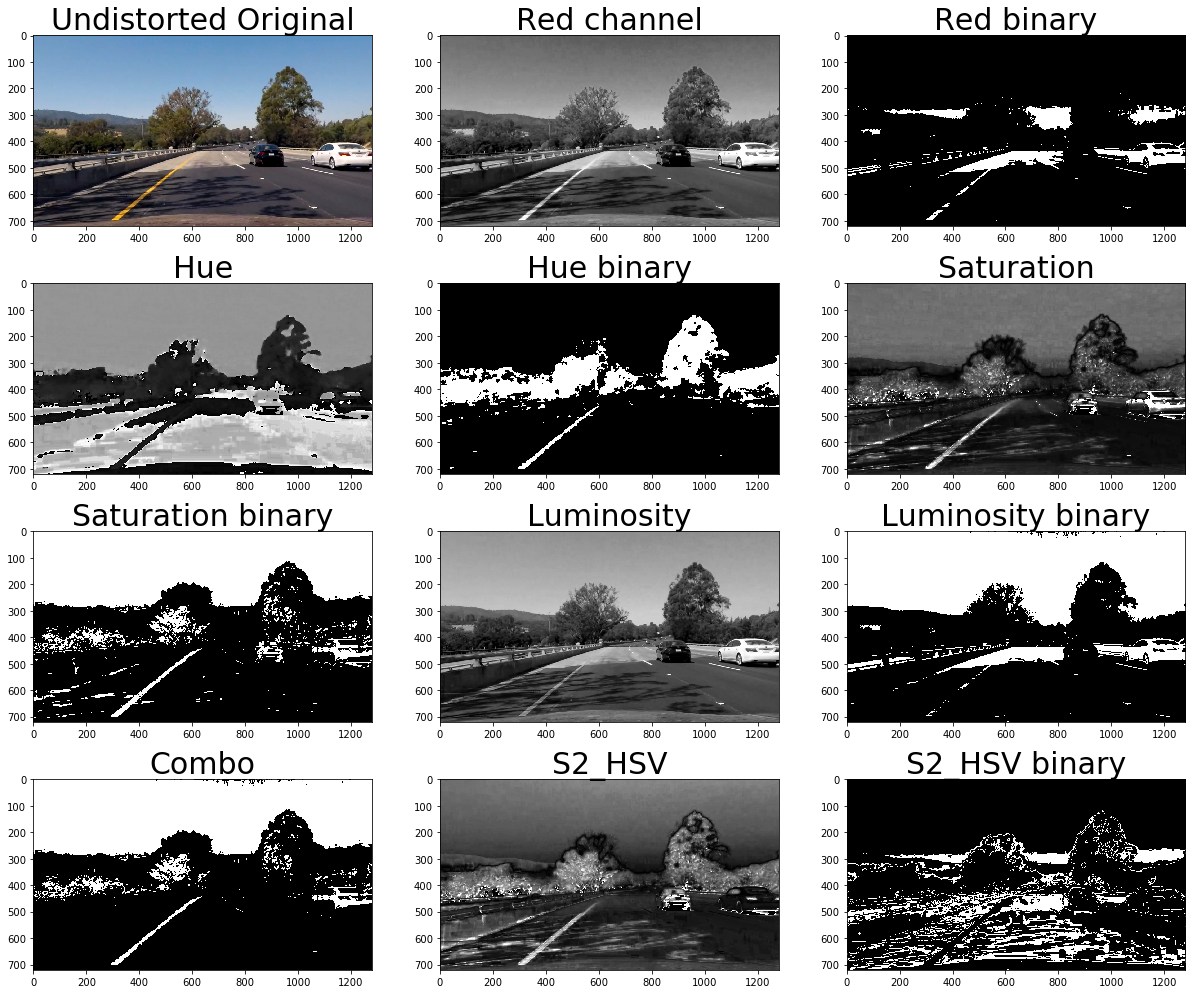

In [8]:
#t = cv2.imread('./test_images/test1.jpg')
#t = cv2.cvtColor(t, cv2.COLOR_BGR2RGB)
#test_undist = undistort_image(t)

# Red channel
R = test_undist[:,:,0]
R_threshold = (170, 255)
R_binary = R_channel(test_undist, R_threshold)

# Hue channel - the lane lines appear dark so try a low threshold
hls = cv2.cvtColor(test_undist, cv2.COLOR_RGB2HLS).astype(np.float)
H = hls[:,:,0]
H_threshold = (16, 100)
H_binary = H_channel(test_undist, H_threshold)

# Luminosity channel
L = hls[:,:,1]
L_threshold = (140, 255)
L_binary = L_channel(test_undist, L_threshold)

# Saturation channel from HLS
S = hls[:,:,2]
S_threshold = (90, 255)
S_binary = S_channel(test_undist, S_threshold)

# Saturation channel from HSV
hsv = cv2.cvtColor(test_undist, cv2.COLOR_RGB2HSV).astype(np.float)
S2 = hsv[:,:,1]
S2_threshold = (30, 50)
S2_binary = S2_channel(test_undist, S2_threshold)

combo = np.zeros_like(S_binary)
combo[((S_binary == 1) & ((H_binary == 1) | (R_binary == 1) | (L_binary == 1)))] = 1


# Visualize results
fig = plt.figure(figsize=(16, 6))

img_list = [[test_undist, 'Undistorted Original'],
            [R, 'Red channel'],
            [R_binary, 'Red binary'],
            [H, 'Hue'],
            [H_binary, 'Hue binary'],
            [S, 'Saturation'],
            [S_binary, 'Saturation binary'],
            [L, 'Luminosity'],
            [L_binary, 'Luminosity binary'],
            [combo, 'Combo'],
            [S2, 'S2_HSV'],
            [S2_binary, 'S2_HSV binary']]

rows = 4
cols = 3

for i in range(len(img_list)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(img_list[i][0], cmap='gray')
    ax.set_title(img_list[i][1], fontsize=30)

plt.subplots_adjust(left=0., right=1, top=1.8, bottom=-0.4)

# Gradient + Color Combination

In [9]:
# Combine the Gradient and Color binary threshold images
def combination(image):
    """
    Purpose: To combine the Gradient and Color binary thresholded images
             and return the combined binary image
    """
    # Get sobel thresholded binaries
    sxbinary = abs_sobel_thresh(image, orient='x', sobel_kernel=9, thresh=(35, 100))
    sybinary = abs_sobel_thresh(image, orient='y', sobel_kernel=9, thresh=(40, 100))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=9, thresh=(0.5, 1.1))

    # Combine the sobel thresholded binaries to extract the lane lines
    #combined = np.zeros_like(dir_binary)
    #combined[((sxbinary == 1) & (sybinary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[(sxbinary == 1) & (dir_binary == 1)] = 1

    # Get R_binary
    R_threshold = (170, 255)
    R_binary = R_channel(image, R_threshold)

    # Get S_binary
    S_threshold = (80, 240)
    S_binary = S_channel(image, S_threshold)

    # Get H_binary
    H_threshold = (16, 60)
    H_binary = H_channel(image, H_threshold)
    
    # Combine H and S channels
    HS_combo = np.zeros_like(H_binary)
    HS_combo[(H_binary == 1) | (S_binary == 1) | (R_binary == 1)] = 1

    # Stack - Gradient threshold in green, Color threshold in blue
    #color_binary = np.dstack((np.zeros_like(combined), combined, HS_combo))
    color_binary = np.dstack((np.zeros_like(combined), combined, combo))

    # Combined
    combined_binary = np.zeros_like(sxbinary)
    #combined_binary[(sxbinary == 1) | (S_binary == 1)] = 1
    #combined_binary[(combined == 1) | (HS_combo == 1)] = 1
    combined_binary[(combined == 1) | (combo == 1)] = 1

    return color_binary, combined_binary

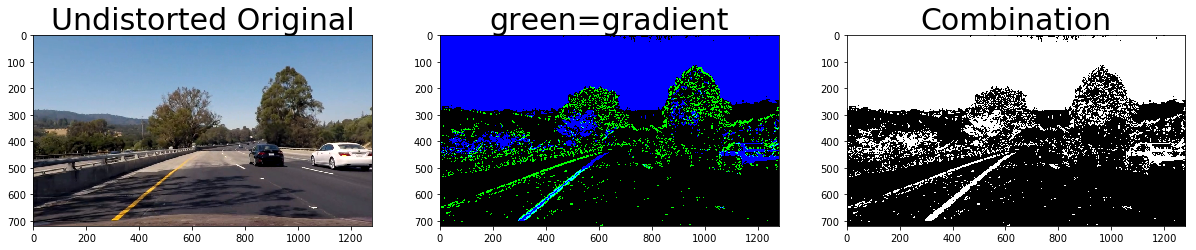

In [10]:
# Generated the color & combined binary images
color_binary, combined_binary = combination(test_undist)

# Visualize results
fig = plt.figure(figsize=(16, 6))

img_list = [[test_undist, 'Undistorted Original'],
            [color_binary, 'green=gradient'],
            [combined_binary, 'Combination']]
rows = 1
cols = 3

for i in range(len(img_list)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(img_list[i][0], cmap='gray')
    ax.set_title(img_list[i][1], fontsize=30)

plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)

# Perspective Transform

In [11]:
def src_dst(img):
    """
    Purpose: To define the source and destination quadrangle vertices

    Note: This only needs to be run once

    Outputs: src - the vertices of the input image trapezium
             dst - the vertices of the output image square
    """
    # Get the shape of the imput image
    y = img.shape[0]
    x = img.shape[1]

    # Define the source trapezium around the expected lane line area
    src = np.float32([[x*0.46, y*0.63],     # top left
                     [x*0.54, y*0.63],      # top right
                     [x*0.85, y*0.98],      # bottom right
                     [x*0.17, y*0.98]])     # bottom left

    # Destination points
    dst = np.float32([[300, 0],        # top left
                      [x-300, 0],      # top right
                      [x-300, y],      # bottom right
                      [300, y]])       # bottom left

    return src, dst


def perspective_map(image, src, dst):
    """
    Purpose: To define the Perspective Transform of the input image according to the
             input source and destination points
    
    Outputs: Minv - the inverse Perspective Mapping
             warped - the resultant transformation of the input image to a "top-down" view
    """
    # Get the shape of the imput image
    y = img.shape[0]
    x = img.shape[1]

    # Get transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Get inverse transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp to top down view
    warped = cv2.warpPerspective(image, M, (x, y), flags=cv2.INTER_LINEAR)

    return Minv, warped


def region_of_interest(img):
    """
    Purpose: To draw the trapezium over the image
             This is the area which will be transformed into a "birds eye" view
    """
    # Get the shape of the imput image
    y = img.shape[0]
    x = img.shape[1]

    # Points for drawing the trapezium
    pts = np.array([[x*0.46, y*0.63],
                    [x*0.54, y*0.63],
                    [x*0.85, y*0.98],
                    [x*0.17, y*0.98]],
                  np.int32)
    pts = pts.reshape((-1,1,2))
    
    return cv2.polylines(img, [pts], True, (0,255,0), thickness=3)

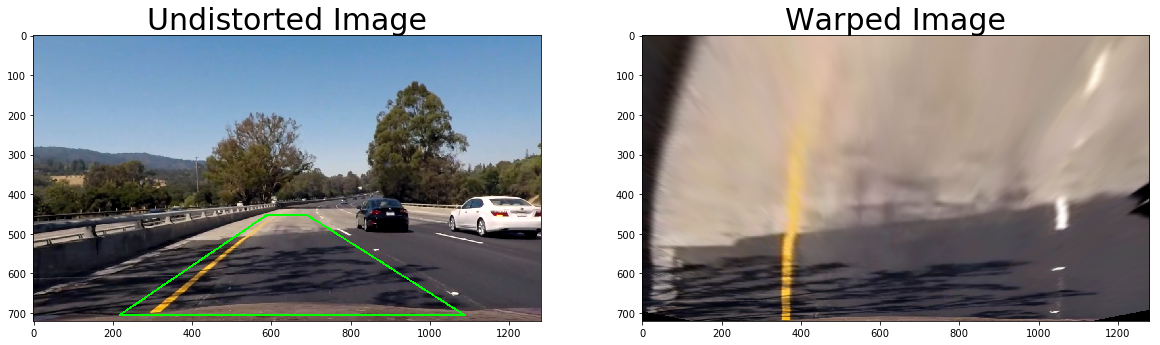

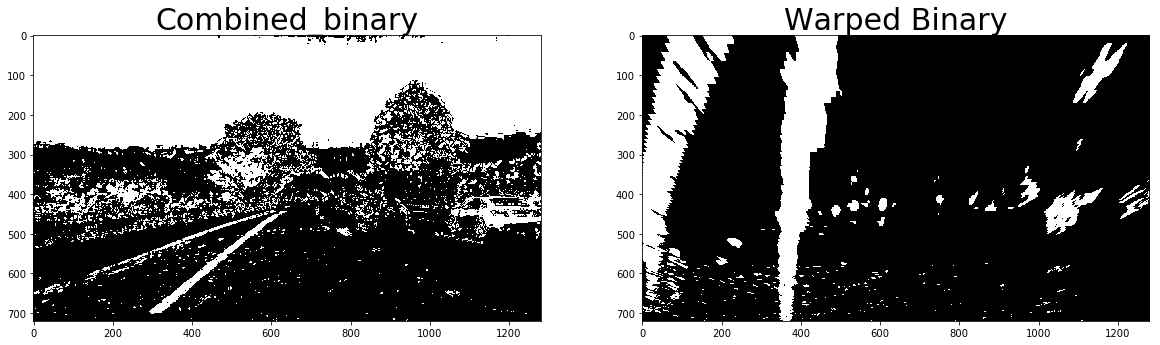

In [12]:
# Obtain the source and destination points
src, dst = src_dst(test_undist)

test_undist_trap = np.copy(test_undist)
trapezium = region_of_interest(test_undist_trap)

Minv_test, warped = perspective_map(test_undist, src, dst)

Minv, binary_warped = perspective_map(combined_binary, src, dst)

# Visualize warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(trapezium)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)

f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combined_binary', fontsize=30)
ax4.imshow(binary_warped, cmap='gray')
ax4.set_title('Warped Binary', fontsize=30)

# Class Line()

In [13]:
# Define a class to keep track of past variables
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False

        # x values of the last n fits of the line
        self.recent_xfitted = []

        # average x values of the fitted line over the last n iterations
        self.bestx = None

        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None

        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]

        # radius of curvature of the line in some units
        self.radius_of_curvature = []           #None

        # distance in meters of vehicle center from the line
        self.line_base_pos = []      #None

        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')

        # x values for detected line pixels
        self.allx = None

        # y values for detected line pixels
        self.ally = None

# Define a lane line class for the left and right lane
llane = Line()
rlane = Line()

# Histogram

In [14]:
def get_hist(image):
    """
    Purpose: Take histogram of bottom half of image, all columns and one channel.
             Histogram should clearly indicate the lane lines.
    
    Input: A binary thresholded, warped image (ie top-down perspective).
    
    Output: The maximum value on the left and right halves of the histogram, assuming
            that these are the x positions of the base of the left and right lane lines
    """
    histogram = np.sum(image[np.int(image.shape[0]/2):,:], axis=0)

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    return leftx_base, rightx_base

calculated left_base 360
calculated right_base 1053


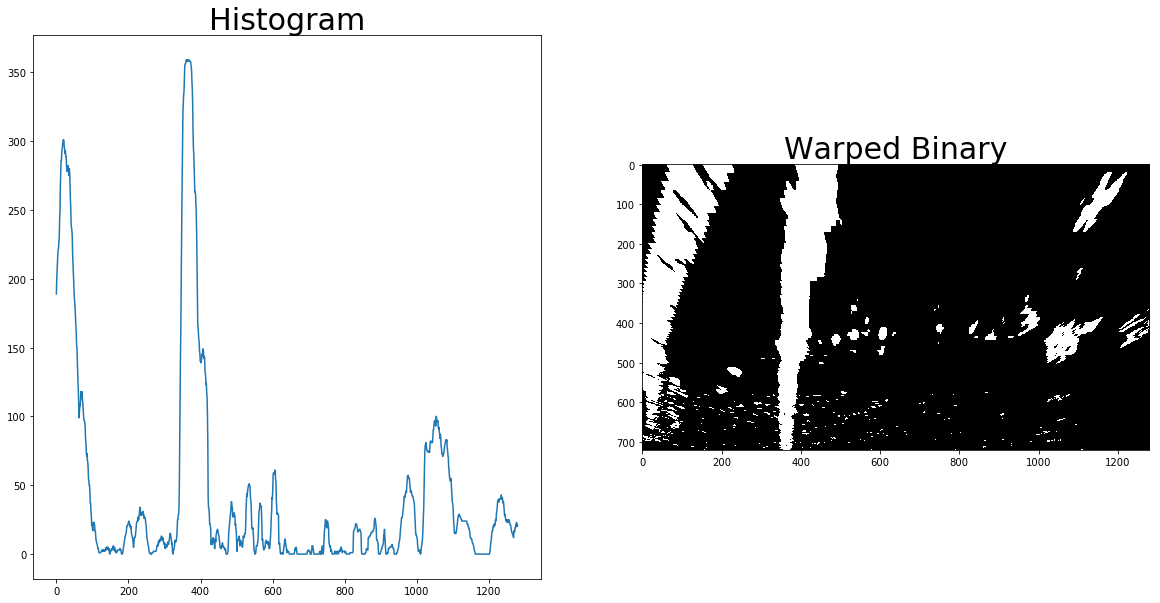

In [15]:
"""
leftx_base: The assumed base of the left lane line
rightx_base: The assumed base of the right lane line
"""
leftx_base, rightx_base = get_hist(binary_warped)

histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)

print('calculated left_base', leftx_base)
print('calculated right_base', rightx_base)

# Visualize images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot(histogram)
ax1.set_title('Histogram', fontsize=30)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Binary', fontsize=30)

# Lane Detection

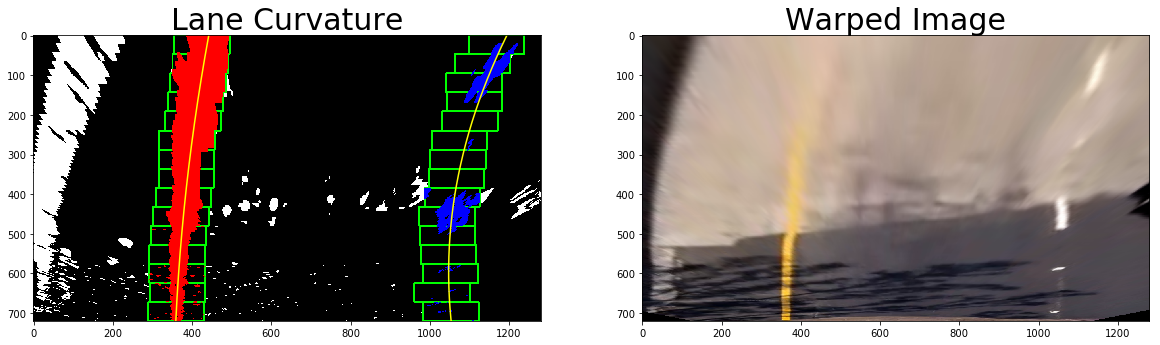

In [16]:
def get_poly_first_image(binary_warped, leftx_base, rightx_base):
    """
    Purpose: To implement Sliding Windows and Fit a Polynomial to the first video image

    Input: Binary warped image
    
    Output: Binary warped image with windows and lanes

    Strategy:
    - Divide the image height into equally spaced rows
    - Define a window in each row
    - Center the first window around the base of each lane as determined in the histogram
    - Count the number of pixels inside each window
    - If greater than minpix, center each window around the mean of all the pixels inside the window
    - Get all the pixels inside the windows (leftx and lefty...)
    - Get the binomial coefficients of the curve that fits all the pixels in the windows (left_fit)
    - Define the coordinates of the lane line curve (left_fitx, ploty)
    """
    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to re-center window
    minpix = 50
    # Define list of windows movements
    lwin_list = []
    dlwin_list = []
    rwin_list = []
    drwin_list = []

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), thickness=4)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), thickness=4)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                          & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                           & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # Append the base position to win_list
        lwin_list.append(leftx_current)
        rwin_list.append(rightx_current)
        # Append the delta increment to dwin_list
        if len(lwin_list) > 1:
            dlwin_list.append(lwin_list[-1] - lwin_list[-2])
            drwin_list.append(rwin_list[-1] - rwin_list[-2])

        # If found > minpix pixels, re-center the next window to the mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        # If found < minpix pixels, examine dwin_list for previous movements and move accordingly
        else:
            dlwin_avg = sum(dlwin_list[-5:]) / 5
            leftx_current = int(leftx_current + dlwin_avg)
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            drwin_avg = sum(drwin_list[-5:]) / 5
            rightx_current = int(rightx_current + drwin_avg)

    # Concatenate the arrays of indices
    # left_lane_inds is the list of all indices of pixels in all the windows
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If points are detected in the left or right lanes, update self.allx and self.ally
    # If points aren't detected, don't update
    # Left lane
    if (leftx.size == 0) | (lefty.size == 0):
        llane.detected = False
    else:
        llane.detected = True
        llane.allx = leftx
        llane.ally = lefty
    # Right lane
    if (rightx.size == 0) | (righty.size == 0):
        rlane.detected = False
    else:
        rlane.detected = True
        rlane.allx = rightx
        rlane.ally = righty

    # Fit a second order polynomial to each
    left_fit = np.polyfit(llane.ally, llane.allx, 2)
    right_fit = np.polyfit(rlane.ally, rlane.allx, 2)

    # Get the difference in fit coefficients if the lane was previously detected
    # Do this prior to update current fit
    if llane.detected == True:
        llane.diffs = llane.current_fit - left_fit
    if rlane.detected == True:
        rlane.diffs = rlane.current_fit - right_fit
    
    # Update the current coefficients
    llane.current_fit = left_fit
    rlane.current_fit = right_fit

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = llane.current_fit[0]*ploty**2 + llane.current_fit[1]*ploty + llane.current_fit[2]
    right_fitx = rlane.current_fit[0]*ploty**2 + rlane.current_fit[1]*ploty + rlane.current_fit[2]
    # Store the fitx values in the class for averaging purposes
    llane.recent_xfitted.insert(0, left_fitx)
    rlane.recent_xfitted.insert(0, right_fitx)

#    # Assume that after this function a line was detected    # Don't need this anymore?????
#    llane.detected = True
#    rlane.detected = True

    return out_img, ploty



### Visualize the result

out_img, ploty = get_poly_first_image(binary_warped, leftx_base, rightx_base)

# Plot each pixel in the windows to a color
out_img[llane.ally, llane.allx] = [255, 0, 0]
out_img[rlane.ally, rlane.allx] = [0, 0, 255]
# Display output image with windows and colored pixels
# Plot the lane curve onto the output image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(out_img)
ax1.set_title('Lane Curvature', fontsize=30)
ax1.plot(llane.recent_xfitted[0], ploty, color='yellow')
ax1.plot(rlane.recent_xfitted[0], ploty, color='yellow')
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)

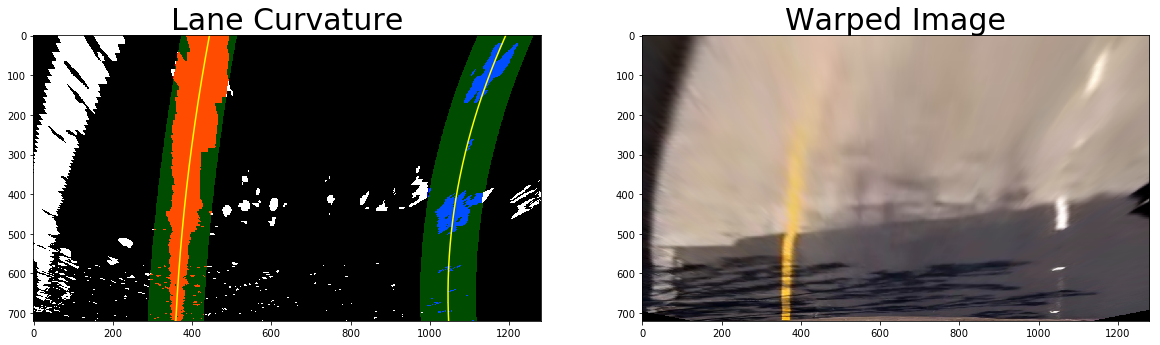

In [17]:
def get_poly_subs_image(binary_warped):
    """
    Purpose: To fit a polynomial to all but the first image

    Input: Binary warped image
    
    Ouput: None

    Strategy:
    - Follow the strategy above but skip the window definition step.
      Use the curve from the previous image
    """
    # Set the width of the curve +/- margin
    margin = 70

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Caluculate the curve values
    left_curve_vals = llane.current_fit[0]*(nonzeroy**2) + llane.current_fit[1]*nonzeroy + llane.current_fit[2]
    right_curve_vals = rlane.current_fit[0]*(nonzeroy**2) + rlane.current_fit[1]*nonzeroy + rlane.current_fit[2]

    # left_lane_inds is the list of all indices between the curve +- margin
    left_lane_inds = ((nonzerox > (left_curve_vals - margin))
                      & (nonzerox < (left_curve_vals + margin))) 
    right_lane_inds = ((nonzerox > (right_curve_vals - margin))
                       & (nonzerox < (right_curve_vals + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If points are detected in the left or right lanes, update self.allx and self.ally
    # If points aren't detected, don't update
    # Left lane
    if (leftx.size == 0) | (lefty.size == 0):
        llane.detected = False
    else:
        llane.detected = True
        llane.allx = leftx
        llane.ally = lefty
    # Right lane
    if (rightx.size == 0) | (righty.size == 0):
        rlane.detected = False
    else:
        rlane.detected = True
        rlane.allx = rightx
        rlane.ally = righty

    # Define limit - if the number of detected pixels is below a threshold,
    # run sliding windows on the next image.
    thresh = 15 * 50    # no. windows * min pixels per window
    if len(llane.allx < thresh):
        llane.detected = False
    if len(rlane.allx < thresh):
        rlane.detected = False

    # Fit a second order polynomial to each
    left_fit = np.polyfit(llane.ally, llane.allx, 2)
    right_fit = np.polyfit(rlane.ally, rlane.allx, 2)

    # Get the difference in fit coefficients if the lane was previously detected
    # Do this prior to update current fit
    if llane.detected == True:
        llane.diffs = llane.current_fit - left_fit
    if rlane.detected == True:
        rlane.diffs = rlane.current_fit - right_fit
    
    # Update the current coefficients
    llane.current_fit = left_fit
    rlane.current_fit = right_fit

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = llane.current_fit[0]*ploty**2 + llane.current_fit[1]*ploty + llane.current_fit[2]
    right_fitx = rlane.current_fit[0]*ploty**2 + rlane.current_fit[1]*ploty + rlane.current_fit[2]
    # Store the fitx values in the class for averaging purposes
    llane.recent_xfitted.insert(0, left_fitx)
    rlane.recent_xfitted.insert(0, right_fitx)

    return ploty



### Visualize the result

ploty = get_poly_subs_image(binary_warped)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[llane.ally, llane.allx] = [255, 0, 0]
out_img[rlane.ally, rlane.allx] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 70
left_line_window1 = np.array([np.transpose(np.vstack([llane.recent_xfitted[0]-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([llane.recent_xfitted[0]+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([rlane.recent_xfitted[0]-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([rlane.recent_xfitted[0]+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(result)
ax1.set_title('Lane Curvature', fontsize=30)
ax1.plot(llane.recent_xfitted[0], ploty, color='yellow')
ax1.plot(rlane.recent_xfitted[0], ploty, color='yellow')
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)

err 3.32707928895


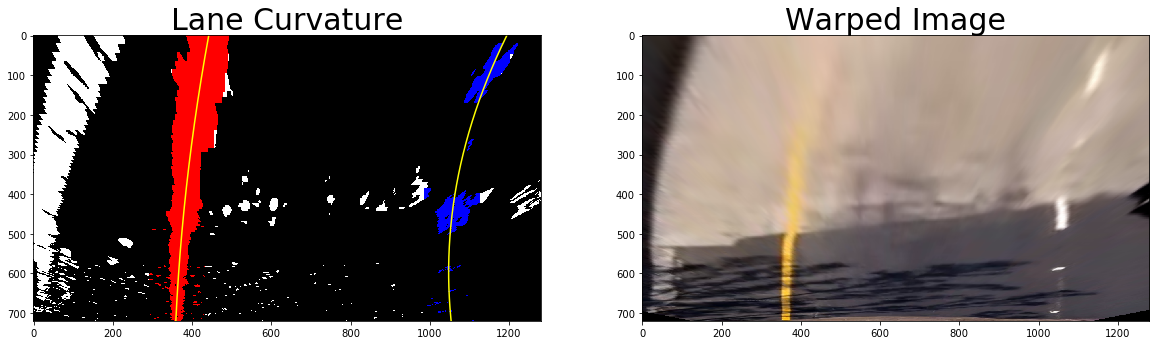

In [36]:
def are_lanes_parallel(ploty, threshold):
    """
    Purpose: To determine whether the lanes are parallel

    Method: Calculate the gradient of each curve and if the error >= threshold, the lanes
            are not parallel.
    """
    n = 5        # Number of gradient segments
    period = np.floor(len(ploty) / n) - 1
    m_left = []
    m_right = []
    error = []

    # Get n gradient segments from the left and right curves
    for i in range(n):
        m_left.append((llane.recent_xfitted[0][(i+1)*period] - llane.recent_xfitted[0][i*period])
                      / (ploty[(i+1)*period] - ploty[i*period]))
        m_right.append((rlane.recent_xfitted[0][(i+1)*period] - rlane.recent_xfitted[0][i*period])
                       / (ploty[(i+1)*period] - ploty[i*period]))
        # Get n error segments from the left and right curves
        error.append(np.absolute(m_left[i] - m_right[i]))

    if sum(error)  >= threshold:
        print('err', sum(error))
        return False
    else:
        return True


def is_incorrect_lane():
    """
    Purpose: Find out which lane is incorrect

    Method: Compare the difference in current curve gradients with previous curve gradients
            The incorrect lane is the one that differs most from the average of it's
            previous lanes.
    """
    n = 5        # Number of gradient segments
    period = np.floor(len(ploty) / n) - 1
    # Lane gradients
    m_left = []
    m_right = []
#    for i in range(len(llane.recent_xfitted)):
#        m_left.append((ploty[-1] - ploty[0]) / (llane.recent_xfitted[i][0] - llane.recent_xfitted[i][-1]))
#    for i in range(len(rlane.recent_xfitted)):
#        m_right.append((ploty[-1] - ploty[0]) / (rlane.recent_xfitted[i][0] - rlane.recent_xfitted[i][-1]))

    # Get n gradient segments from the left and right curves
    for j in range(len(llane.recent_xfitted)):
        for i in range(n):
            l = []
            l.append((llane.recent_xfitted[j][(i+1)*period] - llane.recent_xfitted[j][i*period])
                     / (ploty[(i+1)*period] - ploty[i*period]))
        m_left.append(sum(l) / len(l))
    for j in range(len(rlane.recent_xfitted)):
        for i in range(n):
            r = []
            r.append((rlane.recent_xfitted[j][(i+1)*period] - rlane.recent_xfitted[j][i*period])
                     / (ploty[(i+1)*period] - ploty[i*period]))
        m_right.append(sum(r) / len(r))



#    print('llane.recent_xfitted', len(llane.recent_xfitted))

#    print('m_left', m_left, sum(m_left), len(m_left))
#    print('m_right', m_right, sum(m_right), len(m_right))

    # Find the average gradients
    if len(m_left) > 1:
        avg_m_left = sum(m_left[1:]) / len(m_left[1:])
        avg_m_right = sum(m_right[1:]) / len(m_right[1:])

#        print('avg_m_left', avg_m_left)
#        print('avg_m_right', avg_m_right)
        # Find difference from current to average
        diff_left = np.absolute(m_left[0] - avg_m_left)
        diff_right = np.absolute(m_right[0] - avg_m_right)

#        print('diff_left', diff_left)
#        print('diff_right', diff_right)
#        print('!!!!!!!', len(m_left))
        #  Return the most different lane
        if (diff_left > diff_right) & (len(m_left) > n):
            print('left is wrong')
            return 'left'
        elif (diff_left < diff_right) & (len(m_left) > n):
            print('right is wrong')
            return 'right'
        else:
            return None


def get_parallel_lanes(binary_warped, ploty, threshold, dist):
    """
    Purpose: To get parallel lanes

    Method: - If the lanes are not parallel then perform window sliding method and check if 
              they are parallel.
            - If still not parallel then:
                o Check which lane is incorrect
                o For the incorrect lane, displace a copy of the correct lane to where the
                  incorrect lane should be

    Inputs: ploty
            threshold - the threshold for determining if lines are parallel or not
            dist - the average distance between the two curves
    """
    # Check if lanes are parallel and create parallel lanes if they are not
    # If the lanes are not parallel, use the sliding window method to re-determine the curve
    if not are_lanes_parallel(ploty, threshold):
        # Remove the non-parallel lane from self.recent_xfitted
        del llane.recent_xfitted[0]
        del rlane.recent_xfitted[0]
        # Run histogram and sliding windows
        leftx_base, rightx_base = get_hist(binary_warped)
        out_img, ploty = get_poly_first_image(binary_warped, leftx_base, rightx_base)

        # If lanes are still not parallel, check which lane is incorrect
        if not are_lanes_parallel(ploty, threshold):
            incor = is_incorrect_lane()

            # Displace the correct lane to where the incorrect lane should be
            if incor == 'left':
                llane.recent_xfitted[0] = sum(llane.recent_xfitted[1:]) / len(llane.recent_xfitted[1:])
#                llane.recent_xfitted[0] = rlane.recent_xfitted[0] - dist
                return
            if incor == 'right':
#                print('r_xfitted[0]', rlane.recent_xfitted[0])
#                print('~~~~~~~~~~~`')
                rlane.recent_xfitted[0] = sum(rlane.recent_xfitted[1:]) / len(rlane.recent_xfitted[1:])
#                print('r_xfitted[0] NEW', rlane.recent_xfitted[0])
#                rlane.recent_xfitted[0] = llane.recent_xfitted[0] + dist
                return
    else:
        return


# Test the get parallel lanes function
curve_diff = rlane.recent_xfitted[0] - llane.recent_xfitted[0]
curve_diff_avg = sum(curve_diff) / len(curve_diff)
get_parallel_lanes(binary_warped, ploty, 2.5, curve_diff_avg)

# Create an image to draw on and an image to show the selection window
img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Color in left and right line pixels
img[llane.ally, llane.allx] = [255, 0, 0]
img[rlane.ally, rlane.allx] = [0, 0, 255]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Lane Curvature', fontsize=30)
ax1.plot(llane.recent_xfitted[0], ploty, color='yellow')
ax1.plot(rlane.recent_xfitted[0], ploty, color='yellow')
ax1.imshow(img)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)

# Radius of Curvature

In [19]:
def rad_of_curv(image, ploty):
    """
    Purpose: To calculate the radius of curvature of the lane line in real world space (m).
             To calculate the distance of the car left of the center of the lane in meters

    Equation: Rcurve = ((1 + (2*A + B)**2)**1.5) / np.absolute(2*A)

    Input: Undistorted image used to determine where the radius must be measured
           ploty

    Strategy:
    - Choose a point on the y-axis where you want to measure the radius of curvature
    - Assume: lane length = 30m
              lane width = 3.7m
    - Calculate the binomial coefficients in real world space
    - Calculate the radius, in meters, using the equation above
    - Calculate the distance of the car left of the center of the lane in meters
    """
    # Define y-eval as the bottom of the image, where we want to measure the radius of curvature
    y_eval = image.shape[0] - 1

    # Calculate distance between lane lines bases
    # The polynomial x value the bottom of the image is used to determine the cars position
    dist = rlane.recent_xfitted[0][y_eval] - llane.recent_xfitted[0][y_eval]

    # Define conversions in x and y from pixel space to meters
    ym_per_pix = 30 / image.shape[0]
    xm_per_pix = 3.7 / dist
    
    # Fit new polynomials to x and y in real world space
    real_left_coeffs = np.polyfit(ploty*ym_per_pix, llane.recent_xfitted[0]*xm_per_pix, 2)
    real_right_coeffs = np.polyfit(ploty*ym_per_pix, rlane.recent_xfitted[0]*xm_per_pix, 2)

    # Calculate the radii of curvature in meters
    l_rad = (((1 + (2*real_left_coeffs[0] + real_left_coeffs[1])**2)**1.5)
             / np.absolute(2*real_left_coeffs[0]))
    r_rad = (((1 + (2*real_right_coeffs[0] + real_right_coeffs[1])**2)**1.5)
             / np.absolute(2*real_right_coeffs[0]))

    # Insert the radius for averaging
    llane.radius_of_curvature.insert(0, l_rad)
    rlane.radius_of_curvature.insert(0, r_rad)

    # Calculate the distance of the car left of the center of the lane in meters
    car_pos = image.shape[1]/2
    lane_center = llane.recent_xfitted[0][y_eval]+(dist/2)
    offcenter = (lane_center - car_pos) * xm_per_pix
    
    # Insert offcenter values for averaging
    llane.line_base_pos.insert(0, offcenter)

rad_of_curv(binary_warped, ploty)
print('Radius of Curvature - Left: {:.1f}m'.format(llane.radius_of_curvature[0]))
print('Radius of Curvature - Right: {:.1f}m'.format(rlane.radius_of_curvature[0]))
print('Distance left of center: {:.2f}m'.format(llane.line_base_pos[0]))

Radius of Curvature - Left: 1696.6m
Radius of Curvature - Right: 476.0m
Distance left of center: 0.34m


# Warp to Original Image

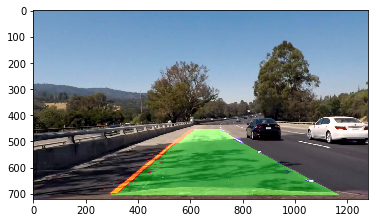

In [20]:
def unwarp(binary_warped, undist, ploty, Minv):
    """
    Purpose: Unwarp the binary image and display the detected lane over the original image

    Input: binary warped image, undistorted original image
           ploty, Minv

    Output: Unwarped image with superimposed lane lines and detected lane
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([llane.recent_xfitted[0], ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rlane.recent_xfitted[0], ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Draw lines onto color_warp
    color_warp[llane.ally, llane.allx] = [255, 0, 0]
    color_warp[rlane.ally, rlane.allx] = [0, 0, 255]

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.4, 0)

    return result

new_image = unwarp(binary_warped, test_undist, ploty, Minv)
plt.imshow(new_image)

# Advanced Lane Finding Method

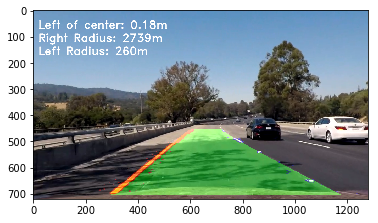

In [26]:
"""
This is the main cell that processes each image
"""

def add_lanes_to_image(image):
    # Udistort a RGB image
    undist = undistort_image(image)

    # Apply a combination of gradient and color filters to the undistorted image
    # and return a binary thresholded image
    # Get sobel thresholded binaries
    ksize = 15
    sxbinary = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    sybinary = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.5, 1.3))
    # Combine the sobel thresholded binaries to extract the lane lines
    combined = np.zeros_like(sxbinary)
    combined[((sxbinary == 1) & (sybinary == 1)) | ((mag_binary == 1) & (dir_binary == 1))
             | ((sxbinary == 1) & (dir_binary == 1))] = 1
    
    # Get R_binary
    R_threshold = (170, 255)
    R_binary = R_channel(undist, R_threshold)
    # Get H_binary
    H_threshold = (16, 100)
    H_binary = H_channel(undist, H_threshold)
    # Get L_binary
    L_threshold = (140, 255)
    L_binary = L_channel(undist, L_threshold)
    # Get S_binary
    S_threshold = (90, 255)
    S_binary = S_channel(undist, S_threshold)
    # Combine color channels
    combo = np.zeros_like(S_binary)
    combo[((S_binary == 1) & ((H_binary == 1) | (R_binary == 1) | (L_binary == 1)))] = 1

    # Combine them
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(combined == 1) | (combo == 1)] = 1

    # Calculate the source and destination points on the image
    src, dst = src_dst(combined_binary)
    # Do a perspective transform to the "top-down" view
    Minv, binary_warped = perspective_map(combined_binary, src, dst)

    if llane.detected == False:
        # This is the first image
        # Get the base of the left and right lanes from the histogram of the binary warped image
        leftx_base, rightx_base = get_hist(binary_warped)
        # Implement sliding windows and fit a polynomial
        out_img, ploty = get_poly_first_image(binary_warped, leftx_base, rightx_base)
    else:
        # These are subsequent images
        # Calculate the polynomial coefficients
        ploty = get_poly_subs_image(binary_warped)

    # Trim list to last n values
    n = 10
    # x-values of last n left curves
    if len(llane.recent_xfitted) > n:
        del llane.recent_xfitted[n:]
    llane.bestx = sum(llane.recent_xfitted) / n
    # x-values of last n right curves
    if len(rlane.recent_xfitted) > n:
        del rlane.recent_xfitted[n:]
    rlane.bestx = sum(rlane.recent_xfitted) / n
    # Last n left lane radii of curvature
    if len(llane.radius_of_curvature) > n:
        del llane.radius_of_curvature[n:]
    # Last n right lane radii of curvature
    if len(rlane.radius_of_curvature) > n:
        del rlane.radius_of_curvature[n:]
    # Last n left-of-center offests
    if len(llane.line_base_pos) > n:
        del llane.line_base_pos[n:]

    # Compare parallel status of right and left curves
    curve_diff = rlane.recent_xfitted[0] - llane.recent_xfitted[0]
    curve_diff_avg = sum(curve_diff) / len(curve_diff)

    # Check if the lanes are parallel
    # If not then do the window sliding method
    # If still not parallel then work out which lane is incorrect and
    # displace the correct lane where the incorrect one should be.
    not_parallel_threshold = 2.5
    get_parallel_lanes(binary_warped, ploty, not_parallel_threshold, curve_diff_avg)

    # Calculate the radius of curvature in meters
    rad_of_curv(undist, ploty)

    # Produce the resultant processed image
    processed_image = unwarp(binary_warped, undist, ploty, Minv)

    # Calculate and display an averaged radius of curvature
    # averaging left
    left_smooth_radius = sum(llane.radius_of_curvature) / len(llane.radius_of_curvature)
    cv2.putText(processed_image, 'Left Radius: {:.0f}m'.format(left_smooth_radius), (20,170),
                cv2.FONT_HERSHEY_DUPLEX, 1.4, (255,255,255), 2, cv2.LINE_AA, False)
    
    # averaging right
    right_smooth_radius = sum(rlane.radius_of_curvature) / len(rlane.radius_of_curvature)
    cv2.putText(processed_image, 'Right Radius: {:.0f}m'.format(right_smooth_radius), (20,120),
                cv2.FONT_HERSHEY_DUPLEX, 1.4, (255,255,255), 2, cv2.LINE_AA, False)

    # Calculate and display an averaged distance of car left of center of lane
    smooth_offset = sum(llane.line_base_pos) / len(llane.line_base_pos)
    cv2.putText(processed_image, 'Left of center: {:.2f}m'.format(smooth_offset), (20,70),
                cv2.FONT_HERSHEY_DUPLEX, 1.4, (255,255,255), 2, cv2.LINE_AA, False)


    return processed_image

# Test an image
new_image = add_lanes_to_image(test_image)
plt.imshow(new_image)

In [22]:
def process_image(image):
    result = add_lanes_to_image(image)

    return result

# Project Video

In [23]:
### project_video

""" TRY WITHOUT PARALLEL LINES AND COMPARE"""

# Define a lane line class for the left and right lane
llane = Line()
rlane = Line()

# Input the video, runs each image through 'process_image' and saves the new video
video_output = 'project_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
clip2 = clip1.fl_image(process_image)
%time clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [09:25<00:00,  2.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 21min 30s, sys: 17.8 s, total: 21min 48s
Wall time: 9min 26s


# Challenge Video

In [37]:
### challenge_video

# Define a lane line class for the left and right lane
llane = Line()
rlane = Line()

# Input the video, runs each image through 'process_image' and saves the new video
video_output = 'challenge_output.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
clip2 = clip1.fl_image(process_image)
%time clip2.write_videofile(video_output, audio=False)

err 3.32707928895
err 3.32707928895
[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


  0%|          | 1/485 [00:00<04:00,  2.02it/s]

err 3.37688153171
err 3.32707928895


  0%|          | 2/485 [00:00<03:59,  2.02it/s]

err 3.41191122242


  1%|          | 5/485 [00:02<03:48,  2.10it/s]

err 2.50923340502
err 2.63206800671
right is wrong


  1%|          | 6/485 [00:02<03:45,  2.13it/s]

err 2.61797897131
err 2.76231645091
right is wrong


  1%|▏         | 7/485 [00:03<03:43,  2.14it/s]

err 2.6351175168
err 2.72673779911
right is wrong


  2%|▏         | 8/485 [00:03<03:42,  2.14it/s]

err 2.92996188371
err 4.73460961861
left is wrong


  2%|▏         | 9/485 [00:04<03:44,  2.12it/s]

err 4.94515361732
err 5.0370924844
left is wrong


  2%|▏         | 10/485 [00:04<03:48,  2.08it/s]

err 5.04103243458
err 5.61009058018
left is wrong


  2%|▏         | 11/485 [00:05<03:47,  2.08it/s]

err 4.94963017251
err 4.12377606883
left is wrong


  2%|▏         | 12/485 [00:05<03:47,  2.08it/s]

err 4.64469340661
err 3.83809861486
left is wrong


  3%|▎         | 13/485 [00:06<03:44,  2.11it/s]

err 4.21223125932


  4%|▍         | 19/485 [00:08<03:33,  2.19it/s]

err 2.79342989344
err 2.79342989344
left is wrong


  4%|▍         | 20/485 [00:09<03:32,  2.19it/s]

err 2.67625196798


  8%|▊         | 41/485 [00:18<03:18,  2.24it/s]

err 2.71592141742


  9%|▊         | 42/485 [00:19<03:19,  2.22it/s]

err 2.95842456709


  9%|▉         | 43/485 [00:19<03:20,  2.20it/s]

err 2.87546452952


  9%|▉         | 44/485 [00:20<03:21,  2.18it/s]

err 2.93271948207


  9%|▉         | 45/485 [00:20<03:22,  2.18it/s]

err 3.07671312687


  9%|▉         | 46/485 [00:21<03:25,  2.14it/s]

err 2.6967686357


 14%|█▎        | 66/485 [00:30<03:09,  2.21it/s]

err 3.48349957808
err 3.48349957808
left is wrong


 14%|█▍        | 67/485 [00:30<03:09,  2.21it/s]

err 3.56509822687
err 3.68770652119
left is wrong


 14%|█▍        | 68/485 [00:31<03:14,  2.14it/s]

err 3.65465897827
err 3.62044863329
left is wrong


 14%|█▍        | 69/485 [00:31<03:15,  2.13it/s]

err 3.72616137759
err 4.12981606313
left is wrong


 14%|█▍        | 70/485 [00:31<03:13,  2.14it/s]

err 4.0035312992
err 3.82664361861
right is wrong


 15%|█▍        | 71/485 [00:32<03:11,  2.16it/s]

err 4.04857780073
err 3.72437377353
right is wrong


 15%|█▍        | 72/485 [00:32<03:11,  2.15it/s]

err 4.19773919997
err 3.4536980558
right is wrong


 15%|█▌        | 73/485 [00:33<03:10,  2.16it/s]

err 3.85369586496
err 3.63575338776
right is wrong


 15%|█▌        | 74/485 [00:33<03:09,  2.17it/s]

err 4.00760562552
err 3.49919839063
right is wrong


 15%|█▌        | 75/485 [00:34<03:08,  2.17it/s]

err 3.97562822098


 16%|█▌        | 77/485 [00:35<03:07,  2.17it/s]

err 4.00218879431
err 4.00218879431
left is wrong


 16%|█▌        | 78/485 [00:35<03:06,  2.18it/s]

err 4.00813525391
err 3.76478706472
left is wrong


 16%|█▋        | 79/485 [00:36<03:07,  2.17it/s]

err 3.88825693301
err 3.54750286666
left is wrong


 16%|█▋        | 80/485 [00:36<03:08,  2.15it/s]

err 3.84759470582
err 3.75829851942
left is wrong


 17%|█▋        | 81/485 [00:37<03:12,  2.10it/s]

err 4.0288911546
err 3.99615849496
left is wrong


 17%|█▋        | 82/485 [00:37<03:10,  2.11it/s]

err 3.90567890405
err 3.57272481322
left is wrong


 17%|█▋        | 83/485 [00:38<03:09,  2.12it/s]

err 3.7902806954
err 3.47986276162
left is wrong


 17%|█▋        | 84/485 [00:38<03:09,  2.12it/s]

err 3.74068665775
err 3.55615255117
left is wrong


 18%|█▊        | 85/485 [00:38<03:07,  2.14it/s]

err 3.88761329023
err 3.76166849133
left is wrong


 18%|█▊        | 86/485 [00:39<03:05,  2.15it/s]

err 4.05061163784
err 3.83962794824
left is wrong


 18%|█▊        | 87/485 [00:39<03:05,  2.14it/s]

err 4.55004122129
err 4.098788121
left is wrong


 18%|█▊        | 88/485 [00:40<03:05,  2.14it/s]

err 4.96895083206
err 4.81013592965
left is wrong


 18%|█▊        | 89/485 [00:40<03:02,  2.17it/s]

err 5.22165125919
err 4.97556408672
left is wrong


 19%|█▊        | 90/485 [00:41<03:00,  2.19it/s]

err 5.01088759391
err 4.6858541599
left is wrong


 19%|█▉        | 91/485 [00:41<02:59,  2.20it/s]

err 5.08976761574
err 4.95952936052
right is wrong


 19%|█▉        | 92/485 [00:42<02:58,  2.21it/s]

err 5.19609832274
err 4.95647497218
right is wrong


 19%|█▉        | 93/485 [00:42<02:59,  2.18it/s]

err 4.907147793
err 4.64026506723
right is wrong


 19%|█▉        | 94/485 [00:43<02:59,  2.18it/s]

err 4.56837631233
err 4.49733533422
right is wrong


 20%|█▉        | 95/485 [00:43<02:57,  2.20it/s]

err 4.66105699991
err 4.54710641492
right is wrong


 20%|█▉        | 96/485 [00:43<02:57,  2.19it/s]

err 5.02702953715


 20%|██        | 98/485 [00:44<02:56,  2.19it/s]

err 3.8138723295
err 3.8138723295
right is wrong


 20%|██        | 99/485 [00:45<02:56,  2.19it/s]

err 3.67330019443
err 2.62031168351
left is wrong


 21%|██        | 100/485 [00:45<02:56,  2.19it/s]

err 2.8044538931
err 2.68231514941
left is wrong


 21%|██        | 101/485 [00:46<02:56,  2.17it/s]

err 2.67003745203


 21%|██        | 102/485 [00:46<02:57,  2.16it/s]

err 2.57001396583


 21%|██▏       | 104/485 [00:47<02:53,  2.20it/s]

err 2.54561969305
err 2.54561969305
left is wrong


 22%|██▏       | 105/485 [00:48<02:52,  2.20it/s]

err 2.7750815484


 25%|██▍       | 119/485 [00:54<02:43,  2.23it/s]

err 2.69375875697
err 2.69375875697
right is wrong


 25%|██▍       | 120/485 [00:54<02:45,  2.21it/s]

err 3.51705525536
err 2.73221892218
right is wrong


 25%|██▍       | 121/485 [00:55<02:44,  2.21it/s]

err 3.39887414048
err 2.71456799531
right is wrong


 25%|██▌       | 122/485 [00:55<02:44,  2.21it/s]

err 3.20579882446
err 2.6934705662
right is wrong


 25%|██▌       | 123/485 [00:56<02:43,  2.21it/s]

err 3.16271706431


 26%|██▌       | 124/485 [00:56<02:43,  2.21it/s]

err 2.96045624852


 26%|██▌       | 125/485 [00:57<02:42,  2.22it/s]

err 2.84063619052
err 8.87357938902
right is wrong


 26%|██▌       | 126/485 [00:57<02:41,  2.22it/s]

err 7.45126169835


 26%|██▌       | 127/485 [00:57<02:41,  2.22it/s]

err 2.86011784137


 41%|████      | 197/485 [01:29<02:09,  2.22it/s]

err 3.47229675459
err 3.47229675459
right is wrong


 41%|████      | 198/485 [01:29<02:10,  2.20it/s]

err 3.87285209825
err 2.94451419152
right is wrong


 41%|████      | 199/485 [01:30<02:10,  2.20it/s]

err 3.32225869852
err 3.45348225671
right is wrong


 41%|████      | 200/485 [01:30<02:09,  2.20it/s]

err 3.71444397378


 44%|████▎     | 212/485 [01:36<02:02,  2.22it/s]

err 3.52182034545
err 3.52182034545
right is wrong


 44%|████▍     | 213/485 [01:36<02:04,  2.18it/s]

err 3.94744835389


 46%|████▋     | 225/485 [01:42<01:59,  2.17it/s]

err 2.58558234369
err 2.58558234369
right is wrong


 47%|████▋     | 226/485 [01:42<01:58,  2.18it/s]

err 2.96612038714
err 2.80753289867
right is wrong


 47%|████▋     | 227/485 [01:43<01:57,  2.19it/s]

err 3.16211829706
err 3.09352677582
right is wrong


 47%|████▋     | 229/485 [01:43<01:56,  2.20it/s]

err 3.53133046199
err 3.53133046199
right is wrong


 47%|████▋     | 230/485 [01:44<01:55,  2.21it/s]

err 3.55305330865


 50%|████▉     | 242/485 [01:49<01:54,  2.13it/s]

err 2.51029257624
err 2.51029257624
right is wrong


 50%|█████     | 243/485 [01:50<01:55,  2.10it/s]

err 2.57500483419


 52%|█████▏    | 251/485 [01:53<01:45,  2.22it/s]

err 3.28361754105
err 3.28361754105
right is wrong


 52%|█████▏    | 252/485 [01:54<01:46,  2.18it/s]

err 3.36316032605
err 2.83817818269
right is wrong


 52%|█████▏    | 253/485 [01:54<01:46,  2.19it/s]

err 3.13926312862
err 2.98223623913
right is wrong


 56%|█████▌    | 272/485 [02:03<01:44,  2.04it/s]

err 2.7891112465
err 2.76144139514
right is wrong


 56%|█████▋    | 274/485 [02:04<01:42,  2.05it/s]

err 2.67907623286
err 2.67907623286
right is wrong


 57%|█████▋    | 276/485 [02:05<01:37,  2.14it/s]

err 3.8999411291
err 3.8999411291
right is wrong


 57%|█████▋    | 277/485 [02:05<01:38,  2.10it/s]

err 4.14290515589
err 4.38648648213
right is wrong


 57%|█████▋    | 278/485 [02:06<01:37,  2.12it/s]

err 4.69845642999
err 4.63539008364
right is wrong


 58%|█████▊    | 279/485 [02:06<01:36,  2.13it/s]

err 4.97174011692
err 4.01065408783
right is wrong


 58%|█████▊    | 280/485 [02:07<01:37,  2.11it/s]

err 4.23732222679
err 3.85849225764
right is wrong


 58%|█████▊    | 281/485 [02:07<01:36,  2.11it/s]

err 4.08551811673
err 3.85867519809
right is wrong


 58%|█████▊    | 282/485 [02:08<01:35,  2.12it/s]

err 4.09066506125
err 4.02186958659
right is wrong


 58%|█████▊    | 283/485 [02:08<01:35,  2.12it/s]

err 4.29374737256
err 3.62069926731
right is wrong


 59%|█████▊    | 284/485 [02:09<01:35,  2.11it/s]

err 3.80238098315
err 3.72067856351
right is wrong


 59%|█████▉    | 285/485 [02:09<01:35,  2.09it/s]

err 4.2400646182


 71%|███████   | 343/485 [02:36<01:08,  2.09it/s]

err 2.53970604645
err 2.53970604645
right is wrong


 76%|███████▌  | 367/485 [02:47<00:54,  2.16it/s]

err 2.62196192282
err 2.62196192282
right is wrong


 76%|███████▌  | 368/485 [02:48<00:53,  2.17it/s]

err 2.63368673394


 82%|████████▏ | 398/485 [03:01<00:39,  2.22it/s]

err 3.24435857401
err 3.24435857401
left is wrong


 82%|████████▏ | 399/485 [03:02<00:39,  2.17it/s]

err 3.38574555429


 83%|████████▎ | 401/485 [03:02<00:40,  2.09it/s]

err 3.09621459399
err 3.09621459399
left is wrong


 83%|████████▎ | 402/485 [03:03<00:39,  2.08it/s]

err 2.81420202297
err 2.81420202297
left is wrong


 83%|████████▎ | 403/485 [03:03<00:39,  2.09it/s]

err 3.00495426491
err 3.03831175717
left is wrong


 84%|████████▎ | 405/485 [03:04<00:38,  2.08it/s]

err 2.71681841648
err 2.71681841648
left is wrong


 84%|████████▎ | 406/485 [03:05<00:37,  2.10it/s]

err 3.23400002666
err 3.33971244181
left is wrong


 84%|████████▍ | 407/485 [03:05<00:37,  2.08it/s]

err 3.53501155936
err 2.81770441707
left is wrong


 84%|████████▍ | 408/485 [03:06<00:36,  2.12it/s]

err 2.71627355938
err 2.70717251334
left is wrong


 90%|█████████ | 438/485 [03:20<00:22,  2.06it/s]

err 4.19847570874
err 4.19847570874
right is wrong


 91%|█████████ | 439/485 [03:20<00:22,  2.04it/s]

err 2.89662949431


 92%|█████████▏| 446/485 [03:24<00:19,  2.01it/s]

err 2.7344696689
err 2.69042691739
right is wrong


 92%|█████████▏| 447/485 [03:24<00:19,  1.93it/s]

err 2.78262716948
err 2.69479096053
right is wrong


 92%|█████████▏| 448/485 [03:25<00:19,  1.90it/s]

err 2.78911047688
err 2.53175268891
left is wrong


 99%|█████████▉| 482/485 [03:41<00:01,  2.02it/s]

err 3.55144082733
err 3.55144082733
left is wrong


100%|█████████▉| 483/485 [03:42<00:00,  2.05it/s]

err 3.74942183552
err 3.40825194914
left is wrong


100%|█████████▉| 484/485 [03:42<00:00,  2.07it/s]

err 3.75435419898
err 3.43356678825
left is wrong


100%|██████████| 485/485 [03:43<00:00,  2.08it/s]

err 3.75465684254
err 3.43356678825
left is wrong


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 8min 15s, sys: 7.32 s, total: 8min 23s
Wall time: 3min 44s


# Harder Challenge Video

In [38]:
### harder_challenge_video

# Define a lane line class for the left and right lane
llane = Line()
rlane = Line()

# Input the video, runs each image through 'process_image' and saves the new video
video_output = 'harder_challenge_output.mp4'
clip1 = VideoFileClip("./harder_challenge_video.mp4")
clip2 = clip1.fl_image(process_image)
%time clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_output.mp4
[MoviePy] Writing video harder_challenge_output.mp4


  1%|          | 9/1200 [00:04<10:25,  1.90it/s]

err 3.12783684907
err 2.54837757402
right is wrong


  1%|          | 10/1200 [00:05<10:33,  1.88it/s]

err 3.29528110088


  1%|          | 11/1200 [00:05<10:36,  1.87it/s]

err 3.13050994903
err 2.78450955663
right is wrong


  1%|          | 12/1200 [00:06<10:55,  1.81it/s]

err 3.36045107161
err 2.82869892542
right is wrong


  1%|          | 13/1200 [00:06<10:52,  1.82it/s]

err 3.31488665814
err 2.84571875704
right is wrong


  1%|          | 14/1200 [00:07<10:58,  1.80it/s]

err 3.54697450241
err 3.0005024777
right is wrong


  1%|▏         | 15/1200 [00:07<10:39,  1.85it/s]

err 3.83215419738
err 3.08540316985
right is wrong


  1%|▏         | 16/1200 [00:08<10:34,  1.87it/s]

err 4.05802926854
err 3.22435489211
right is wrong


  1%|▏         | 17/1200 [00:08<10:31,  1.87it/s]

err 4.42204354175
err 3.69031332186
right is wrong


  2%|▏         | 18/1200 [00:09<10:47,  1.83it/s]

err 4.65021071621
err 3.59511375101
right is wrong


  2%|▏         | 19/1200 [00:09<10:39,  1.85it/s]

err 4.70346710709


  2%|▏         | 21/1200 [00:11<10:21,  1.90it/s]

err 2.67862005366
err 2.67862005366
left is wrong


  2%|▏         | 22/1200 [00:11<10:20,  1.90it/s]

err 2.68689499293
err 3.8569079325
right is wrong


  2%|▏         | 23/1200 [00:12<10:18,  1.90it/s]

err 4.85954244023
err 4.21990936566
right is wrong


  2%|▏         | 24/1200 [00:12<10:17,  1.90it/s]

err 5.07154639533
err 4.34273084916
right is wrong


  2%|▏         | 25/1200 [00:13<10:15,  1.91it/s]

err 5.12894477857
err 4.4567269808
right is wrong


  2%|▏         | 26/1200 [00:13<10:11,  1.92it/s]

err 5.34570299523
err 4.58253475771
right is wrong


  2%|▏         | 27/1200 [00:14<10:16,  1.90it/s]

err 5.41519467855
err 4.8451228006
right is wrong


  2%|▏         | 28/1200 [00:14<10:30,  1.86it/s]

err 5.65871545779
err 4.99773586414
right is wrong


  2%|▏         | 29/1200 [00:15<10:23,  1.88it/s]

err 5.78159089857
err 5.1702078894
right is wrong


  2%|▎         | 30/1200 [00:15<10:23,  1.88it/s]

err 5.88180119132
err 5.1571695754
right is wrong


  3%|▎         | 31/1200 [00:16<10:16,  1.90it/s]

err 5.93698205027
err 5.30893690534
right is wrong


  3%|▎         | 32/1200 [00:16<10:18,  1.89it/s]

err 6.09988114044
err 5.21431881822
right is wrong


  3%|▎         | 33/1200 [00:17<10:14,  1.90it/s]

err 6.03266075868
err 5.57463695747
right is wrong


  3%|▎         | 34/1200 [00:17<10:09,  1.91it/s]

err 6.46520044532
err 6.29681966967
right is wrong


  3%|▎         | 35/1200 [00:18<10:05,  1.92it/s]

err 7.47353519249
err 5.75121768527
right is wrong


  3%|▎         | 36/1200 [00:18<10:09,  1.91it/s]

err 7.12026590348
err 6.71580860581
right is wrong


  3%|▎         | 37/1200 [00:19<10:04,  1.92it/s]

err 8.14524303055
err 7.58890430665
right is wrong


  3%|▎         | 38/1200 [00:19<10:03,  1.93it/s]

err 9.28411029403
err 8.00173719233
right is wrong


  3%|▎         | 39/1200 [00:20<10:03,  1.92it/s]

err 9.80972307283
err 7.51183338695
right is wrong


  3%|▎         | 40/1200 [00:20<10:00,  1.93it/s]

err 10.2879951897


  4%|▎         | 44/1200 [00:23<10:03,  1.92it/s]

err 6.20382195989
err 6.20382195989
right is wrong


  4%|▍         | 45/1200 [00:23<10:03,  1.92it/s]

err 10.4963728677
err 9.81886038336
left is wrong


  4%|▍         | 46/1200 [00:24<10:00,  1.92it/s]

err 11.8767276571
err 9.90392362496
left is wrong


  4%|▍         | 47/1200 [00:24<10:07,  1.90it/s]

err 12.0395005506
err 9.6122336574
left is wrong


  4%|▍         | 48/1200 [00:25<10:02,  1.91it/s]

err 12.3139847308
err 7.22296897674
left is wrong


  4%|▍         | 49/1200 [00:25<10:03,  1.91it/s]

err 11.735557026
err 10.7483131126
left is wrong


  4%|▍         | 50/1200 [00:26<10:02,  1.91it/s]

err 12.8646608434
err 10.9158114488
left is wrong


  4%|▍         | 51/1200 [00:26<10:05,  1.90it/s]

err 12.9662749121
err 11.0997237177
left is wrong


  4%|▍         | 52/1200 [00:27<10:03,  1.90it/s]

err 13.1419633327


  4%|▍         | 54/1200 [00:28<09:59,  1.91it/s]

err 5.84822903397
err 5.84822903397
right is wrong


  5%|▍         | 55/1200 [00:28<10:02,  1.90it/s]

err 11.9691512478
err 5.63377069569
right is wrong


  5%|▍         | 56/1200 [00:29<10:05,  1.89it/s]

err 12.3142134457
err 11.8142179166
left is wrong


  5%|▍         | 57/1200 [00:29<09:57,  1.91it/s]

err 14.3928917938
err 12.441543397
left is wrong


  5%|▍         | 58/1200 [00:30<09:55,  1.92it/s]

err 14.6353458761
err 12.4632355419
left is wrong


  5%|▍         | 59/1200 [00:30<09:54,  1.92it/s]

err 14.3650171972
err 12.6459270957
left is wrong


  5%|▌         | 60/1200 [00:31<09:49,  1.93it/s]

err 14.6346669668
err 12.5366831822
left is wrong


  5%|▌         | 61/1200 [00:31<09:57,  1.91it/s]

err 14.0576585503
err 11.9624491017
right is wrong


  5%|▌         | 62/1200 [00:32<09:54,  1.91it/s]

err 14.1481740026
err 12.1689871305
right is wrong


  5%|▌         | 63/1200 [00:32<10:01,  1.89it/s]

err 14.4991332449
err 12.4944299732
right is wrong


  5%|▌         | 64/1200 [00:33<09:55,  1.91it/s]

err 15.078440577
err 12.789553133
right is wrong


  5%|▌         | 65/1200 [00:33<09:53,  1.91it/s]

err 15.5547934035
err 13.0471195884
right is wrong


  6%|▌         | 66/1200 [00:34<09:50,  1.92it/s]

err 15.8865154733


  6%|▌         | 73/1200 [00:37<09:15,  2.03it/s]

err 2.946852349


  6%|▌         | 74/1200 [00:38<09:33,  1.96it/s]

err 2.53857484189
err 2.63423188965
right is wrong


  6%|▋         | 75/1200 [00:38<09:33,  1.96it/s]

err 2.77826072609
err 2.59459207681
right is wrong


  6%|▋         | 76/1200 [00:39<09:24,  1.99it/s]

err 2.77009844809
err 2.5319299435
right is wrong


  6%|▋         | 77/1200 [00:39<09:20,  2.00it/s]

err 2.75368365508
err 3.70497068968
left is wrong


  6%|▋         | 78/1200 [00:40<09:14,  2.02it/s]

err 2.79527813568


  7%|▋         | 89/1200 [00:45<08:24,  2.20it/s]

err 2.92105710783
err 14.1628095491
left is wrong


  8%|▊         | 90/1200 [00:45<08:34,  2.16it/s]

err 13.2372822636


  8%|▊         | 94/1200 [00:47<08:36,  2.14it/s]

err 6.06070392821
err 6.06070392821
left is wrong


  8%|▊         | 95/1200 [00:48<08:38,  2.13it/s]

err 6.4662855923
err 2.54655007908
left is wrong


  8%|▊         | 97/1200 [00:49<08:38,  2.13it/s]

err 7.3364000688
err 7.3364000688
left is wrong


  8%|▊         | 98/1200 [00:49<08:38,  2.13it/s]

err 6.00719738984
err 7.15415327275
right is wrong


  8%|▊         | 99/1200 [00:50<08:34,  2.14it/s]

err 4.86564425434
err 5.64115579892
left is wrong


  8%|▊         | 100/1200 [00:50<08:34,  2.14it/s]

err 5.35620948334


  8%|▊         | 102/1200 [00:51<08:42,  2.10it/s]

err 5.04732901796
err 5.04732901796
right is wrong


  9%|▊         | 103/1200 [00:51<08:45,  2.09it/s]

err 4.04079891354
err 4.46634889093
right is wrong


  9%|▊         | 104/1200 [00:52<08:46,  2.08it/s]

err 3.57436313954
err 3.91468058888
right is wrong


  9%|▉         | 105/1200 [00:52<08:40,  2.10it/s]

err 3.00146035533
err 3.49507060025
right is wrong


  9%|▉         | 106/1200 [00:53<08:41,  2.10it/s]

err 3.11971728948
err 6.39041464897
left is wrong


  9%|▉         | 107/1200 [00:53<08:38,  2.11it/s]

err 9.06651421107


 10%|▉         | 114/1200 [00:57<08:30,  2.13it/s]

err 2.59668891912
err 2.50120203034
right is wrong


 10%|▉         | 115/1200 [00:57<08:34,  2.11it/s]

err 2.76237123657
err 2.78899597057
left is wrong


 10%|▉         | 116/1200 [00:58<08:34,  2.11it/s]

err 3.07346624761


 10%|▉         | 117/1200 [00:58<08:36,  2.10it/s]

err 8.25586100475
err 9.83094819624
right is wrong


 10%|▉         | 118/1200 [00:59<08:36,  2.10it/s]

err 8.53901227707
err 9.98596428793
right is wrong


 10%|▉         | 119/1200 [00:59<08:36,  2.09it/s]

err 8.75322926424
err 9.46121954627
right is wrong


 10%|█         | 120/1200 [00:59<08:36,  2.09it/s]

err 8.52009905635
err 9.68462271167
right is wrong


 10%|█         | 121/1200 [01:00<08:38,  2.08it/s]

err 9.1143013642
err 9.6919242419
right is wrong


 10%|█         | 122/1200 [01:00<08:36,  2.09it/s]

err 8.34799126949
err 3.83666109001
right is wrong


 10%|█         | 123/1200 [01:01<08:36,  2.09it/s]

err 3.69215056777
err 3.3538922525
left is wrong


 10%|█         | 124/1200 [01:01<08:35,  2.09it/s]

err 3.3659459601
err 3.41384011015
right is wrong


 10%|█         | 125/1200 [01:02<08:33,  2.09it/s]

err 3.53195229583
err 3.36746171489
left is wrong


 10%|█         | 126/1200 [01:02<08:33,  2.09it/s]

err 3.82957647238
err 3.71792845157
right is wrong


 11%|█         | 127/1200 [01:03<08:36,  2.08it/s]

err 4.01223971772
err 3.43615209673
right is wrong


 11%|█         | 128/1200 [01:03<08:34,  2.08it/s]

err 4.59934977943
err 3.43718182908
right is wrong


 11%|█         | 129/1200 [01:04<08:35,  2.08it/s]

err 4.67146860272
err 3.32507142547
right is wrong


 11%|█         | 130/1200 [01:04<08:32,  2.09it/s]

err 4.09372671588
err 3.5797950588
right is wrong


 11%|█         | 131/1200 [01:05<08:28,  2.10it/s]

err 4.65685150089
err 3.85786692594
right is wrong


 11%|█         | 132/1200 [01:05<08:25,  2.11it/s]

err 4.71615877141
err 3.57395650411
right is wrong


 11%|█         | 133/1200 [01:06<08:29,  2.09it/s]

err 3.67006116074
err 2.72315282904
right is wrong


 11%|█         | 134/1200 [01:06<08:25,  2.11it/s]

err 3.46342342219


 11%|█▏        | 135/1200 [01:07<08:24,  2.11it/s]

err 3.5936047589
err 2.65708756044
right is wrong


 12%|█▏        | 139/1200 [01:08<08:17,  2.13it/s]

err 7.78855778678
err 7.78855778678
right is wrong


 12%|█▏        | 140/1200 [01:09<08:15,  2.14it/s]

err 9.36964552802
err 2.81715797613
right is wrong


 12%|█▏        | 144/1200 [01:11<08:11,  2.15it/s]

err 4.5773582325
err 4.5773582325
right is wrong


 12%|█▏        | 147/1200 [01:12<08:05,  2.17it/s]

err 3.94620904826
err 4.33551682857
right is wrong


 12%|█▏        | 148/1200 [01:13<08:04,  2.17it/s]

err 2.96170360312
err 6.24781549471
right is wrong


 12%|█▏        | 149/1200 [01:13<08:05,  2.17it/s]

err 7.43107848948
err 2.74836990369
right is wrong


 12%|█▎        | 150/1200 [01:14<08:10,  2.14it/s]

err 7.71775290701


 13%|█▎        | 152/1200 [01:15<08:09,  2.14it/s]

err 3.06804592387
err 3.06804592387
right is wrong


 13%|█▎        | 154/1200 [01:15<08:08,  2.14it/s]

err 2.85954394471
err 2.85954394471
right is wrong


 13%|█▎        | 156/1200 [01:16<08:05,  2.15it/s]

err 3.74456864573
err 3.74456864573
right is wrong


 13%|█▎        | 157/1200 [01:17<08:02,  2.16it/s]

err 8.52860701287
err 10.453110598
right is wrong


 13%|█▎        | 158/1200 [01:17<08:05,  2.14it/s]

err 9.38614124921
err 6.36071294985
right is wrong


 13%|█▎        | 159/1200 [01:18<08:02,  2.16it/s]

err 9.56329740041
err 13.0830978302
right is wrong


 13%|█▎        | 160/1200 [01:18<08:04,  2.15it/s]

err 14.1161633015
err 3.39159370948
left is wrong


 13%|█▎        | 161/1200 [01:19<07:59,  2.17it/s]

err 12.4960247114
err 7.02826107233
right is wrong


 14%|█▎        | 162/1200 [01:19<07:59,  2.16it/s]

err 10.8408032584
err 16.230336237
right is wrong


 14%|█▎        | 163/1200 [01:20<07:59,  2.16it/s]

err 4.01976163464
err 9.31468822665
right is wrong


 14%|█▎        | 164/1200 [01:20<08:00,  2.16it/s]

err 9.4857864607


 14%|█▍        | 165/1200 [01:21<07:56,  2.17it/s]

err 5.9079452019
err 3.68069380167
right is wrong


 14%|█▍        | 167/1200 [01:21<07:54,  2.18it/s]

err 9.3701776793
err 9.3701776793
right is wrong


 14%|█▍        | 168/1200 [01:22<07:54,  2.17it/s]

err 5.9664054749


 14%|█▍        | 170/1200 [01:23<07:52,  2.18it/s]

err 2.51862426187
err 2.51862426187
right is wrong


 14%|█▍        | 171/1200 [01:23<07:57,  2.16it/s]

err 3.18184588617


 14%|█▍        | 172/1200 [01:24<07:55,  2.16it/s]

err 19.2526726682
err 8.12154915747
right is wrong


 14%|█▍        | 173/1200 [01:24<07:53,  2.17it/s]

err 21.4242626326
err 6.81934905918
right is wrong


 14%|█▍        | 174/1200 [01:25<08:01,  2.13it/s]

err 16.1967376086
err 12.4085321705
right is wrong


 15%|█▍        | 175/1200 [01:25<07:58,  2.14it/s]

err 20.0101745489
err 12.9131670313
right is wrong


 15%|█▍        | 176/1200 [01:26<08:03,  2.12it/s]

err 20.9918049377
err 18.0726211868
right is wrong


 15%|█▍        | 177/1200 [01:26<08:01,  2.13it/s]

err 29.752746153
err 23.4655406927
right is wrong


 15%|█▍        | 178/1200 [01:27<07:58,  2.13it/s]

err 35.6510063832
err 29.6625820915
right is wrong


 15%|█▍        | 179/1200 [01:27<07:58,  2.14it/s]

err 46.8441404131
err 21.048020611
right is wrong


 15%|█▌        | 180/1200 [01:27<07:58,  2.13it/s]

err 36.7406070108
err 20.7730732973
left is wrong


 15%|█▌        | 181/1200 [01:28<08:00,  2.12it/s]

err 31.0483161829
err 13.6904738796
right is wrong


 15%|█▌        | 182/1200 [01:28<07:57,  2.13it/s]

err 23.5135047818
err 12.9489856108
right is wrong


 15%|█▌        | 183/1200 [01:29<08:01,  2.11it/s]

err 25.3838125385
err 12.0948961175
right is wrong


 15%|█▌        | 184/1200 [01:29<08:00,  2.12it/s]

err 26.0543273207
err 3.35550853181
right is wrong


 15%|█▌        | 185/1200 [01:30<08:05,  2.09it/s]

err 2.91477273309


 16%|█▌        | 192/1200 [01:33<07:46,  2.16it/s]

err 2.98873045621


 16%|█▌        | 194/1200 [01:34<07:46,  2.16it/s]

err 4.14748542955
err 4.14748542955
left is wrong


 16%|█▋        | 195/1200 [01:34<07:50,  2.14it/s]

err 4.78344142822
err 5.11553853834
right is wrong


 16%|█▋        | 196/1200 [01:35<07:51,  2.13it/s]

err 4.91663163884
err 5.29568504261
right is wrong


 16%|█▋        | 197/1200 [01:35<07:54,  2.11it/s]

err 5.0058827647
err 4.16750441153
right is wrong


 16%|█▋        | 198/1200 [01:36<07:57,  2.10it/s]

err 4.31878524684


 19%|█▉        | 229/1200 [01:51<08:05,  2.00it/s]

err 2.59358179442
err 2.76372644664
left is wrong


 19%|█▉        | 230/1200 [01:51<08:11,  1.97it/s]

err 3.0497498018


 22%|██▏       | 258/1200 [02:05<07:45,  2.03it/s]

err 2.78241883371
err 2.78241883371
left is wrong


 22%|██▏       | 259/1200 [02:05<07:55,  1.98it/s]

err 3.31855598353


 22%|██▏       | 261/1200 [02:06<08:02,  1.95it/s]

err 3.28758360173
err 3.28758360173
left is wrong


 22%|██▏       | 262/1200 [02:07<08:01,  1.95it/s]

err 3.03776916577


 22%|██▏       | 263/1200 [02:07<08:01,  1.95it/s]

err 2.95819626305
err 2.81374128381
left is wrong


 22%|██▏       | 264/1200 [02:08<08:01,  1.94it/s]

err 2.90683920708


 23%|██▎       | 272/1200 [02:12<07:23,  2.09it/s]

err 2.68666741485
err 2.68666741485
left is wrong


 23%|██▎       | 273/1200 [02:12<07:26,  2.08it/s]

err 3.09856094333
err 2.91777034568
left is wrong


 23%|██▎       | 274/1200 [02:13<07:31,  2.05it/s]

err 3.22445325938


 23%|██▎       | 276/1200 [02:14<07:31,  2.05it/s]

err 3.72198826507
err 3.72198826507
right is wrong


 23%|██▎       | 277/1200 [02:14<07:55,  1.94it/s]

err 3.57101612842
err 3.48401002433
right is wrong


 23%|██▎       | 278/1200 [02:15<08:09,  1.88it/s]

err 3.53588085026
err 3.32210869982
right is wrong


 23%|██▎       | 279/1200 [02:15<07:55,  1.94it/s]

err 3.64245335284


 24%|██▎       | 283/1200 [02:17<07:17,  2.10it/s]

err 10.9728528704
err 10.9728528704
right is wrong


 24%|██▎       | 284/1200 [02:18<07:13,  2.11it/s]

err 8.08007247068
err 10.4915631876
left is wrong


 24%|██▍       | 285/1200 [02:18<07:13,  2.11it/s]

err 8.17126914336
err 9.49395692124
right is wrong


 24%|██▍       | 286/1200 [02:19<07:18,  2.08it/s]

err 6.65988939676
err 6.30478620385
left is wrong


 24%|██▍       | 287/1200 [02:19<07:20,  2.07it/s]

err 6.23989815437
err 8.49462108625
left is wrong


 24%|██▍       | 288/1200 [02:19<07:25,  2.05it/s]

err 5.54847196257


 24%|██▍       | 289/1200 [02:20<07:20,  2.07it/s]

err 3.47969200537


 24%|██▍       | 291/1200 [02:21<07:15,  2.09it/s]

err 3.90077672421
err 3.90077672421
right is wrong


 24%|██▍       | 292/1200 [02:21<07:11,  2.10it/s]

err 3.76667696243


 24%|██▍       | 294/1200 [02:22<07:07,  2.12it/s]

err 4.66496004559
err 4.66496004559
right is wrong


 25%|██▍       | 295/1200 [02:23<07:07,  2.11it/s]

err 5.73154411163
err 5.0028880907
right is wrong


 25%|██▍       | 296/1200 [02:23<07:07,  2.11it/s]

err 5.90885393255
err 5.88863845919
right is wrong


 25%|██▍       | 297/1200 [02:24<07:06,  2.12it/s]

err 6.10960447651
err 3.17607645075
right is wrong


 25%|██▍       | 298/1200 [02:24<07:18,  2.06it/s]

err 3.71725890113


 25%|██▌       | 304/1200 [02:27<06:59,  2.14it/s]

err 3.2843183889
err 3.2843183889
right is wrong


 25%|██▌       | 305/1200 [02:28<07:02,  2.12it/s]

err 3.7350529385
err 3.26461673311
right is wrong


 26%|██▌       | 306/1200 [02:28<07:02,  2.11it/s]

err 3.48776160154


 26%|██▌       | 314/1200 [02:32<06:40,  2.21it/s]

err 3.47123189047
err 3.47123189047
right is wrong


 26%|██▋       | 315/1200 [02:32<06:45,  2.18it/s]

err 3.39309876992
err 3.54696055989
right is wrong


 26%|██▋       | 316/1200 [02:32<06:44,  2.18it/s]

err 3.46929097048


 27%|██▋       | 320/1200 [02:34<06:47,  2.16it/s]

err 4.22886185331
err 4.22886185331
right is wrong


 27%|██▋       | 321/1200 [02:35<06:47,  2.16it/s]

err 4.70712714699
err 4.68710657109
right is wrong


 27%|██▋       | 322/1200 [02:35<06:48,  2.15it/s]

err 4.77984398579
err 3.15934934219
left is wrong


 27%|██▋       | 323/1200 [02:36<06:49,  2.14it/s]

err 3.20262236983
err 4.02324180828
left is wrong


 27%|██▋       | 324/1200 [02:36<06:49,  2.14it/s]

err 3.83832415788
err 6.17009772485
left is wrong


 27%|██▋       | 325/1200 [02:37<06:48,  2.14it/s]

err 5.82189414247
err 3.4703255761
right is wrong


 27%|██▋       | 326/1200 [02:37<06:49,  2.14it/s]

err 3.94561589211
err 3.22497035859
right is wrong


 27%|██▋       | 327/1200 [02:38<06:50,  2.13it/s]

err 3.35243863186
err 3.11554995992
right is wrong


 27%|██▋       | 328/1200 [02:38<06:50,  2.13it/s]

err 3.1467426237
err 3.21796844364
right is wrong


 27%|██▋       | 329/1200 [02:39<06:57,  2.09it/s]

err 3.63880355259
err 4.65580242868
left is wrong


 28%|██▊       | 330/1200 [02:39<06:55,  2.09it/s]

err 5.36908152575
err 2.76186335551
right is wrong


 28%|██▊       | 331/1200 [02:40<07:09,  2.03it/s]

err 2.72430215008


 28%|██▊       | 341/1200 [02:44<06:53,  2.08it/s]

err 4.46899032345
err 4.46899032345
left is wrong


 28%|██▊       | 342/1200 [02:45<06:53,  2.07it/s]

err 5.94142179805
err 4.98553437471
left is wrong


 29%|██▊       | 343/1200 [02:45<06:49,  2.09it/s]

err 5.32292939279
err 5.44696723061
right is wrong


 29%|██▊       | 344/1200 [02:46<06:46,  2.10it/s]

err 5.46594066376
err 4.89119812477
right is wrong


 29%|██▉       | 345/1200 [02:46<06:44,  2.11it/s]

err 5.1697120719
err 4.94665464261
right is wrong


 29%|██▉       | 346/1200 [02:47<06:55,  2.06it/s]

err 5.06093284159
err 5.61714079825
right is wrong


 29%|██▉       | 347/1200 [02:47<06:52,  2.07it/s]

err 5.6056847067


 29%|██▉       | 348/1200 [02:48<06:51,  2.07it/s]

err 3.18632069914
err 5.57691734042
left is wrong


 29%|██▉       | 349/1200 [02:48<06:48,  2.08it/s]

err 5.98979023879


 29%|██▉       | 351/1200 [02:49<06:43,  2.11it/s]

err 3.49047299847
err 3.49047299847
left is wrong


 29%|██▉       | 352/1200 [02:49<06:41,  2.11it/s]

err 3.47353989083
err 3.63321005318
left is wrong


 29%|██▉       | 353/1200 [02:50<06:42,  2.11it/s]

err 3.75459622707
err 3.0472496296
left is wrong


 30%|██▉       | 354/1200 [02:50<06:42,  2.10it/s]

err 3.35272551104
err 2.89256489454
left is wrong


 30%|██▉       | 355/1200 [02:51<06:42,  2.10it/s]

err 3.35893452848
err 3.31017052917
left is wrong


 30%|██▉       | 356/1200 [02:51<06:48,  2.07it/s]

err 3.50091497086
err 4.92222308845
left is wrong


 30%|██▉       | 357/1200 [02:52<06:53,  2.04it/s]

err 4.93847774408
err 4.00995756919
left is wrong


 30%|██▉       | 358/1200 [02:52<06:55,  2.03it/s]

err 4.55658483163
err 4.4961184663
left is wrong


 30%|██▉       | 359/1200 [02:53<06:56,  2.02it/s]

err 4.96418334444
err 4.75890194074
left is wrong


 30%|███       | 360/1200 [02:53<06:59,  2.00it/s]

err 5.30646079956
err 5.0330866431
left is wrong


 30%|███       | 361/1200 [02:54<06:58,  2.01it/s]

err 4.69031976469
err 3.48190484155
left is wrong


 30%|███       | 362/1200 [02:54<06:56,  2.01it/s]

err 3.5033393768
err 3.59432366662
left is wrong


 30%|███       | 363/1200 [02:55<06:59,  2.00it/s]

err 3.60530391697
err 4.35710686154
left is wrong


 30%|███       | 364/1200 [02:55<07:02,  1.98it/s]

err 4.15390854663
err 3.80672390177
left is wrong


 30%|███       | 365/1200 [02:56<07:00,  1.98it/s]

err 3.69202215198
err 3.11625414153
left is wrong


 30%|███       | 366/1200 [02:56<07:02,  1.97it/s]

err 3.26238415076


 34%|███▎      | 402/1200 [03:14<07:03,  1.88it/s]

err 7.82443440538
err 7.82443440538
left is wrong


 34%|███▎      | 403/1200 [03:15<07:13,  1.84it/s]

err 8.12605618495
err 7.51436881885
left is wrong


 34%|███▎      | 404/1200 [03:16<07:18,  1.82it/s]

err 7.888885885
err 7.30292790266
left is wrong


 34%|███▍      | 405/1200 [03:16<07:19,  1.81it/s]

err 8.01363978123
err 7.7723325993
left is wrong


 34%|███▍      | 406/1200 [03:17<07:19,  1.81it/s]

err 8.00095359252
err 7.68928790761
left is wrong


 34%|███▍      | 407/1200 [03:17<07:20,  1.80it/s]

err 8.16450997655
err 7.90667906356
left is wrong


 34%|███▍      | 408/1200 [03:18<07:21,  1.79it/s]

err 8.31413552594
err 8.01741802496
left is wrong


 34%|███▍      | 409/1200 [03:18<07:21,  1.79it/s]

err 8.36927947195
err 8.05181246475
left is wrong


 34%|███▍      | 410/1200 [03:19<07:20,  1.79it/s]

err 8.42826145513
err 7.99013164296
left is wrong


 34%|███▍      | 411/1200 [03:19<07:19,  1.79it/s]

err 8.55172417084
err 8.43904117768
left is wrong


 34%|███▍      | 412/1200 [03:20<07:17,  1.80it/s]

err 8.78342702593
err 9.09649004623
left is wrong


 34%|███▍      | 413/1200 [03:21<07:15,  1.81it/s]

err 9.18899105462
err 10.1657020396
left is wrong


 34%|███▍      | 414/1200 [03:21<07:14,  1.81it/s]

err 9.25719362501
err 8.2147553346
left is wrong


 35%|███▍      | 415/1200 [03:22<07:20,  1.78it/s]

err 9.26228937456
err 8.01797043489
left is wrong


 35%|███▍      | 416/1200 [03:22<07:18,  1.79it/s]

err 9.47625012607
err 6.98467581786
left is wrong


 35%|███▍      | 417/1200 [03:23<07:15,  1.80it/s]

err 10.0924398361
err 5.7544922082
left is wrong


 35%|███▍      | 418/1200 [03:23<07:12,  1.81it/s]

err 9.91315485953
err 7.19818664173
left is wrong


 35%|███▍      | 419/1200 [03:24<07:15,  1.79it/s]

err 10.766566167


 35%|███▌      | 421/1200 [03:25<07:04,  1.83it/s]

err 18.7149273017
err 18.7149273017
left is wrong


 35%|███▌      | 422/1200 [03:25<07:04,  1.83it/s]

err 18.8507392601


 36%|███▌      | 434/1200 [03:32<06:34,  1.94it/s]

err 14.567094729
err 14.567094729
left is wrong


 36%|███▋      | 435/1200 [03:32<06:49,  1.87it/s]

err 17.3488326722
err 14.2594646946
left is wrong


 36%|███▋      | 436/1200 [03:33<06:48,  1.87it/s]

err 16.9767066897
err 13.2953906487
left is wrong


 36%|███▋      | 437/1200 [03:33<07:02,  1.81it/s]

err 16.9263730856


 36%|███▋      | 438/1200 [03:34<07:14,  1.75it/s]

err 2.66241366738


 37%|███▋      | 445/1200 [03:37<06:25,  1.96it/s]

err 2.65819561773


 40%|███▉      | 475/1200 [03:51<05:51,  2.06it/s]

err 6.00693692477
err 6.00693692477
left is wrong


 40%|███▉      | 476/1200 [03:52<05:51,  2.06it/s]

err 3.72166641971
err 5.71763713391
left is wrong


 40%|███▉      | 477/1200 [03:52<05:52,  2.05it/s]

err 3.50111355096
err 4.95158335602
left is wrong


 40%|███▉      | 478/1200 [03:53<05:52,  2.05it/s]

err 2.91209908755
err 5.9636802502
left is wrong


 40%|███▉      | 479/1200 [03:53<05:52,  2.05it/s]

err 5.97676530885
err 6.0651450966
left is wrong


 40%|████      | 480/1200 [03:54<05:51,  2.05it/s]

err 6.27434555414
err 8.00266636676
left is wrong


 40%|████      | 481/1200 [03:54<05:49,  2.06it/s]

err 7.13640433067
err 7.73373076854
left is wrong


 40%|████      | 482/1200 [03:55<05:50,  2.05it/s]

err 7.21050071427
err 7.09224967794
left is wrong


 40%|████      | 483/1200 [03:55<05:49,  2.05it/s]

err 6.99365202504
err 7.75427974553
left is wrong


 40%|████      | 484/1200 [03:56<05:49,  2.05it/s]

err 6.40753766756
err 5.585884402
left is wrong


 40%|████      | 485/1200 [03:56<05:48,  2.05it/s]

err 4.74533889165
err 2.94970476211
left is wrong


 40%|████      | 486/1200 [03:57<05:47,  2.05it/s]

err 3.89992722622
err 2.60512676161
left is wrong


 41%|████      | 487/1200 [03:57<05:47,  2.05it/s]

err 3.52133745363
err 2.93284912779
left is wrong


 41%|████      | 488/1200 [03:58<05:46,  2.06it/s]

err 3.53960172053
err 2.76697321741
left is wrong


 41%|████      | 489/1200 [03:58<05:46,  2.05it/s]

err 3.59672758291


 41%|████      | 490/1200 [03:59<05:43,  2.07it/s]

err 3.37157377794


 41%|████      | 491/1200 [03:59<05:44,  2.06it/s]

err 3.20382997024
err 2.64883657163
left is wrong


 41%|████      | 492/1200 [04:00<05:48,  2.03it/s]

err 3.31040780316


 41%|████      | 493/1200 [04:00<05:46,  2.04it/s]

err 3.00302915903


 41%|████      | 494/1200 [04:01<05:44,  2.05it/s]

err 2.9451984515


 41%|████▏     | 495/1200 [04:01<05:45,  2.04it/s]

err 2.83567425734
err 3.07813329107
right is wrong


 41%|████▏     | 496/1200 [04:02<05:46,  2.03it/s]

err 3.273582637
err 3.80406263479
right is wrong


 41%|████▏     | 497/1200 [04:02<05:47,  2.02it/s]

err 3.79667433352
err 4.66534067284
right is wrong


 42%|████▏     | 498/1200 [04:03<05:45,  2.03it/s]

err 4.15247262933
err 5.55485749079
right is wrong


 42%|████▏     | 499/1200 [04:03<05:43,  2.04it/s]

err 4.59851380798
err 5.67041992046
right is wrong


 42%|████▏     | 500/1200 [04:04<05:42,  2.04it/s]

err 4.43705200154
err 4.52302526954
left is wrong


 42%|████▏     | 501/1200 [04:04<05:41,  2.05it/s]

err 4.14125196988


 42%|████▏     | 509/1200 [04:08<05:23,  2.14it/s]

err 18.0997504645
err 18.0997504645
left is wrong


 42%|████▎     | 510/1200 [04:08<05:25,  2.12it/s]

err 13.6502350264
err 6.68290135275
left is wrong


 43%|████▎     | 511/1200 [04:09<05:28,  2.10it/s]

err 5.7429144124
err 5.20918440212
left is wrong


 43%|████▎     | 512/1200 [04:09<05:29,  2.09it/s]

err 3.53725164057
err 4.76289135262
left is wrong


 43%|████▎     | 513/1200 [04:10<05:28,  2.09it/s]

err 3.22774046506
err 5.00314452332
left is wrong


 43%|████▎     | 514/1200 [04:10<05:26,  2.10it/s]

err 3.42917422868


 43%|████▎     | 515/1200 [04:11<05:26,  2.10it/s]

err 2.60920497035


 43%|████▎     | 517/1200 [04:11<05:20,  2.13it/s]

err 3.54409398364
err 3.54409398364
left is wrong


 43%|████▎     | 518/1200 [04:12<05:21,  2.12it/s]

err 3.09358685836
err 2.70195935917
left is wrong


 44%|████▎     | 522/1200 [04:14<05:18,  2.13it/s]

err 2.76784539814
err 2.76784539814
left is wrong


 44%|████▎     | 523/1200 [04:14<05:33,  2.03it/s]

err 4.49955949239


 44%|████▍     | 526/1200 [04:16<05:28,  2.05it/s]

err 2.74886731047
err 4.81061647249
right is wrong


 44%|████▍     | 527/1200 [04:16<05:29,  2.04it/s]

err 4.90728596344
err 5.22137565929
right is wrong


 44%|████▍     | 528/1200 [04:17<05:29,  2.04it/s]

err 5.17073813237
err 5.10028637261
right is wrong


 44%|████▍     | 529/1200 [04:17<05:30,  2.03it/s]

err 5.59231702903
err 5.19075801213
right is wrong


 44%|████▍     | 530/1200 [04:18<05:26,  2.05it/s]

err 5.84510515643
err 5.3774172245
right is wrong


 44%|████▍     | 531/1200 [04:18<05:22,  2.08it/s]

err 6.07800692033
err 4.41004803537
right is wrong


 44%|████▍     | 532/1200 [04:19<05:21,  2.08it/s]

err 4.98356143205
err 7.17393259455
right is wrong


 44%|████▍     | 533/1200 [04:19<05:18,  2.09it/s]

err 7.45166645532
err 4.36548432012
right is wrong


 44%|████▍     | 534/1200 [04:20<05:19,  2.08it/s]

err 5.50151037801


 45%|████▍     | 536/1200 [04:21<05:14,  2.11it/s]

err 2.51355220272
err 2.51355220272
left is wrong


 45%|████▍     | 538/1200 [04:22<05:11,  2.13it/s]

err 3.84315412683
err 3.84315412683
right is wrong


 45%|████▌     | 540/1200 [04:22<05:12,  2.11it/s]

err 3.21561596145
err 3.21561596145
right is wrong


 47%|████▋     | 568/1200 [04:35<04:44,  2.22it/s]

err 3.32543281837
err 3.32543281837
left is wrong


 47%|████▋     | 569/1200 [04:35<04:47,  2.19it/s]

err 3.64772719508
err 2.91613829391
left is wrong


 48%|████▊     | 570/1200 [04:36<04:48,  2.18it/s]

err 4.42604613556


 48%|████▊     | 571/1200 [04:36<05:02,  2.08it/s]

err 2.76451229002


 48%|████▊     | 572/1200 [04:37<05:01,  2.08it/s]

err 2.53793301511
err 3.6130655117
right is wrong


 48%|████▊     | 573/1200 [04:37<04:58,  2.10it/s]

err 3.42711017335


 48%|████▊     | 582/1200 [04:41<04:41,  2.20it/s]

err 3.09888440469


 49%|████▊     | 583/1200 [04:42<04:42,  2.18it/s]

err 3.06010874278


 49%|████▊     | 584/1200 [04:42<04:46,  2.15it/s]

err 2.97490760131
err 2.59072750686
left is wrong


 49%|████▉     | 585/1200 [04:43<04:46,  2.15it/s]

err 5.13873562052
err 3.81175772161
left is wrong


 49%|████▉     | 586/1200 [04:43<04:45,  2.15it/s]

err 3.9951247166


 49%|████▉     | 587/1200 [04:44<04:47,  2.13it/s]

err 3.93340920006


 50%|████▉     | 594/1200 [04:47<04:42,  2.15it/s]

err 4.78647198773


 50%|████▉     | 596/1200 [04:48<04:47,  2.10it/s]

err 6.13482996106
err 6.13482996106
left is wrong


 50%|████▉     | 597/1200 [04:48<04:47,  2.10it/s]

err 6.71417864002


 50%|█████     | 600/1200 [04:50<04:46,  2.10it/s]

err 6.92124125908
err 5.62254321885
left is wrong


 50%|█████     | 601/1200 [04:50<04:43,  2.12it/s]

err 4.76520018638


 56%|█████▋    | 675/1200 [05:26<04:18,  2.03it/s]

err 3.26332285441
err 3.26332285441
right is wrong


 56%|█████▋    | 676/1200 [05:26<04:20,  2.02it/s]

err 3.86169365862
err 2.74219190584
right is wrong


 56%|█████▋    | 677/1200 [05:27<04:23,  1.99it/s]

err 2.54586096251


 57%|█████▋    | 681/1200 [05:29<04:13,  2.05it/s]

err 3.16204713556
err 3.16204713556
left is wrong


 57%|█████▋    | 682/1200 [05:29<04:14,  2.04it/s]

err 4.71658488307


 57%|█████▋    | 684/1200 [05:30<04:09,  2.07it/s]

err 4.04651980333
err 4.04651980333
right is wrong


 57%|█████▋    | 685/1200 [05:31<04:07,  2.08it/s]

err 4.49599184989
err 2.94180321051
right is wrong


 57%|█████▋    | 686/1200 [05:31<04:05,  2.09it/s]

err 5.0179563624
err 6.53315734786
right is wrong


 57%|█████▋    | 687/1200 [05:32<04:03,  2.11it/s]

err 13.0847363191
err 8.71490376741
right is wrong


 57%|█████▋    | 688/1200 [05:32<04:02,  2.11it/s]

err 8.77962575762


 59%|█████▉    | 706/1200 [05:40<03:40,  2.24it/s]

err 7.07672787641
err 7.07672787641
right is wrong


 59%|█████▉    | 707/1200 [05:41<03:41,  2.23it/s]

err 7.58760617356


 59%|█████▉    | 710/1200 [05:42<03:40,  2.22it/s]

err 2.8784467949


 59%|█████▉    | 712/1200 [05:43<03:41,  2.20it/s]

err 3.78556623776
err 3.78556623776
left is wrong


 59%|█████▉    | 713/1200 [05:43<03:44,  2.17it/s]

err 4.36807555996
err 4.2184313415
left is wrong


 60%|█████▉    | 714/1200 [05:44<03:45,  2.16it/s]

err 4.18061295862
err 3.53852393455
left is wrong


 60%|█████▉    | 715/1200 [05:44<03:46,  2.14it/s]

err 3.78030710102
err 3.13279175741
left is wrong


 60%|█████▉    | 716/1200 [05:45<03:47,  2.13it/s]

err 3.26411364388
err 2.78812757755
left is wrong


 60%|█████▉    | 717/1200 [05:45<03:48,  2.11it/s]

err 3.11870866692
err 3.02868757057
left is wrong


 60%|█████▉    | 718/1200 [05:46<03:48,  2.11it/s]

err 3.17063398495
err 2.84640312746
left is wrong


 60%|█████▉    | 719/1200 [05:46<03:49,  2.10it/s]

err 3.24273972618
err 3.02786679627
left is wrong


 60%|██████    | 720/1200 [05:47<03:47,  2.11it/s]

err 3.12875272578
err 2.82010587243
left is wrong


 60%|██████    | 721/1200 [05:47<03:47,  2.10it/s]

err 2.76163309878
err 2.70097931941
left is wrong


 60%|██████    | 722/1200 [05:48<03:47,  2.10it/s]

err 2.60325979635
err 2.70667178498
left is wrong


 60%|██████    | 723/1200 [05:48<03:48,  2.09it/s]

err 2.56866759065
err 2.61869660041
left is wrong


 64%|██████▍   | 770/1200 [06:10<03:31,  2.03it/s]

err 2.69181366118


 64%|██████▍   | 771/1200 [06:11<03:34,  2.00it/s]

err 2.81282081963


 64%|██████▍   | 772/1200 [06:11<03:34,  2.00it/s]

err 2.72617646831
err 2.50668547656
right is wrong


 64%|██████▍   | 773/1200 [06:12<03:37,  1.97it/s]

err 3.47961962077


 64%|██████▍   | 774/1200 [06:12<03:39,  1.94it/s]

err 3.23321051074
err 2.52454306601
left is wrong


 65%|██████▍   | 775/1200 [06:13<03:36,  1.97it/s]

err 3.66439166301
err 2.8438477754
left is wrong


 65%|██████▍   | 776/1200 [06:13<03:34,  1.98it/s]

err 3.8613882903
err 2.81017941579
left is wrong


 65%|██████▍   | 777/1200 [06:14<03:36,  1.95it/s]

err 3.6614967224


 65%|██████▍   | 778/1200 [06:14<03:36,  1.95it/s]

err 3.48901232406


 65%|██████▍   | 779/1200 [06:15<03:35,  1.95it/s]

err 3.2472966515


 65%|██████▌   | 780/1200 [06:15<03:34,  1.96it/s]

err 3.55293454734
err 2.91173617049
left is wrong


 65%|██████▌   | 781/1200 [06:16<03:31,  1.98it/s]

err 3.67422320738
err 3.2442373066
left is wrong


 65%|██████▌   | 782/1200 [06:16<03:29,  1.99it/s]

err 3.72266398692
err 2.81113506303
left is wrong


 65%|██████▌   | 783/1200 [06:17<03:29,  1.99it/s]

err 3.81369420004
err 3.13647705985
left is wrong


 65%|██████▌   | 784/1200 [06:17<03:27,  2.00it/s]

err 4.00034200079
err 3.41615072677
left is wrong


 65%|██████▌   | 785/1200 [06:18<03:27,  2.00it/s]

err 3.88638586338
err 3.40295803153
left is wrong


 66%|██████▌   | 786/1200 [06:18<03:26,  2.01it/s]

err 4.1637961998
err 3.46736509247
left is wrong


 66%|██████▌   | 787/1200 [06:19<03:24,  2.01it/s]

err 4.23565176957
err 3.44660729909
left is wrong


 66%|██████▌   | 788/1200 [06:19<03:24,  2.02it/s]

err 4.18840852032
err 3.70097602262
left is wrong


 66%|██████▌   | 789/1200 [06:20<03:24,  2.01it/s]

err 4.5046351085
err 2.74264789961
right is wrong


 66%|██████▌   | 790/1200 [06:20<03:24,  2.01it/s]

err 3.1359498343
err 3.12997163753
right is wrong


 66%|██████▌   | 791/1200 [06:21<03:25,  1.99it/s]

err 3.2712158678
err 2.98613467813
left is wrong


 66%|██████▌   | 792/1200 [06:21<03:25,  1.98it/s]

err 3.64117054872
err 2.77308572229
left is wrong


 66%|██████▌   | 793/1200 [06:22<03:26,  1.97it/s]

err 3.31413650934
err 3.46039196549
right is wrong


 66%|██████▌   | 794/1200 [06:22<03:25,  1.98it/s]

err 3.42863293141
err 3.19877187654
right is wrong


 66%|██████▋   | 795/1200 [06:23<03:24,  1.98it/s]

err 3.16160136009
err 2.73969299138
right is wrong


 66%|██████▋   | 796/1200 [06:23<03:23,  1.99it/s]

err 2.97255482696


 67%|██████▋   | 809/1200 [06:29<03:02,  2.14it/s]

err 3.39745335435
err 3.28908710273
left is wrong


 68%|██████▊   | 810/1200 [06:30<03:02,  2.14it/s]

err 3.78582694331


 68%|██████▊   | 811/1200 [06:30<03:02,  2.13it/s]

err 3.05441668629


 69%|██████▉   | 827/1200 [06:38<02:51,  2.18it/s]

err 2.51640988882
err 2.51640988882
left is wrong


 69%|██████▉   | 828/1200 [06:38<02:53,  2.15it/s]

err 2.50237143233
err 2.60997206379
left is wrong


 69%|██████▉   | 829/1200 [06:39<02:54,  2.13it/s]

err 2.57840144565
err 2.76416141864
left is wrong


 69%|██████▉   | 830/1200 [06:39<02:54,  2.12it/s]

err 2.57007432968
err 2.51693846063
left is wrong


 70%|██████▉   | 834/1200 [06:41<02:54,  2.10it/s]

err 2.6224301119
err 2.6224301119
left is wrong


 70%|██████▉   | 835/1200 [06:41<02:53,  2.10it/s]

err 2.68024144101
err 2.98319175035
left is wrong


 70%|██████▉   | 836/1200 [06:42<02:55,  2.07it/s]

err 2.74568288379
err 2.59191177062
left is wrong


 70%|██████▉   | 837/1200 [06:42<02:57,  2.04it/s]

err 2.55462130915
err 2.66152826002
left is wrong


 70%|██████▉   | 838/1200 [06:43<02:59,  2.02it/s]

err 2.67820663769
err 2.61015499595
left is wrong


 70%|██████▉   | 839/1200 [06:43<02:59,  2.01it/s]

err 2.64110258968
err 2.55060924811
left is wrong


 70%|███████   | 840/1200 [06:44<02:58,  2.01it/s]

err 2.50645149085


 70%|███████   | 841/1200 [06:44<02:59,  2.00it/s]

err 2.513911182
err 3.13213580116
left is wrong


 70%|███████   | 842/1200 [06:45<03:00,  1.99it/s]

err 3.0616091098
err 2.51635907134
left is wrong


 70%|███████   | 843/1200 [06:45<02:59,  1.98it/s]

err 2.89875620065


 70%|███████   | 844/1200 [06:46<03:02,  1.95it/s]

err 2.76141382962


 70%|███████   | 845/1200 [06:46<03:04,  1.93it/s]

err 2.59790290721


 77%|███████▋  | 923/1200 [07:23<02:06,  2.20it/s]

err 4.04271651002
err 4.04271651002
left is wrong


 77%|███████▋  | 924/1200 [07:24<02:05,  2.20it/s]

err 3.88755971792
err 3.36574308892
left is wrong


 77%|███████▋  | 925/1200 [07:24<02:05,  2.19it/s]

err 3.96627808471
err 3.28771534174
left is wrong


 77%|███████▋  | 926/1200 [07:25<02:05,  2.18it/s]

err 4.3793021631
err 3.75711303524
left is wrong


 77%|███████▋  | 927/1200 [07:25<02:05,  2.18it/s]

err 4.32849572282
err 4.0577775149
left is wrong


 77%|███████▋  | 928/1200 [07:25<02:04,  2.18it/s]

err 4.86333643063
err 4.47045677216
left is wrong


 77%|███████▋  | 929/1200 [07:26<02:04,  2.18it/s]

err 5.28605365066
err 4.39282524896
left is wrong


 78%|███████▊  | 930/1200 [07:26<02:05,  2.15it/s]

err 5.33688205293


 79%|███████▊  | 943/1200 [07:32<01:55,  2.22it/s]

err 2.5816065441
err 2.93416197994
right is wrong


 79%|███████▊  | 944/1200 [07:33<01:55,  2.22it/s]

err 3.17667891008
err 3.77283491056
right is wrong


 79%|███████▉  | 945/1200 [07:33<01:56,  2.20it/s]

err 4.1223303738
err 4.58159063628
right is wrong


 79%|███████▉  | 946/1200 [07:34<01:57,  2.16it/s]

err 5.98460248597
err 5.51163282099
right is wrong


 79%|███████▉  | 947/1200 [07:34<01:57,  2.15it/s]

err 4.57563374637
err 2.71909474729
right is wrong


 79%|███████▉  | 948/1200 [07:35<01:57,  2.15it/s]

err 3.41317428346
err 3.61263886843
left is wrong


 79%|███████▉  | 949/1200 [07:35<01:57,  2.14it/s]

err 3.70254872763
err 3.68956369665
left is wrong


 79%|███████▉  | 950/1200 [07:36<01:56,  2.14it/s]

err 4.59121478175
err 5.0397740546
left is wrong


 79%|███████▉  | 951/1200 [07:36<01:56,  2.14it/s]

err 9.66866559208
err 6.96374483098
left is wrong


 79%|███████▉  | 952/1200 [07:36<01:56,  2.13it/s]

err 8.48119155398
err 4.66698019747
right is wrong


 79%|███████▉  | 953/1200 [07:37<01:54,  2.16it/s]

err 8.92917106339
err 7.51037215636
right is wrong


 80%|███████▉  | 954/1200 [07:37<01:53,  2.16it/s]

err 7.11073576294
err 10.0801016344
right is wrong


 80%|███████▉  | 955/1200 [07:38<01:52,  2.18it/s]

err 8.48701600038


 80%|████████  | 962/1200 [07:41<01:44,  2.28it/s]

err 8.24837948528


 80%|████████  | 965/1200 [07:42<01:43,  2.27it/s]

err 43.495252884


 80%|████████  | 966/1200 [07:43<01:44,  2.25it/s]

err 3.03043028757
err 2.51026211158
right is wrong


 81%|████████  | 967/1200 [07:43<01:44,  2.23it/s]

err 3.58474897711


 81%|████████  | 971/1200 [07:45<01:44,  2.20it/s]

err 9.374325532
err 9.374325532
left is wrong


 81%|████████  | 972/1200 [07:45<01:44,  2.19it/s]

err 7.16637188111
err 6.48623881501
left is wrong


 81%|████████  | 973/1200 [07:46<01:43,  2.19it/s]

err 6.46282145335


 81%|████████▏ | 977/1200 [07:48<01:41,  2.19it/s]

err 7.39578326742
err 7.39578326742
left is wrong


 82%|████████▏ | 978/1200 [07:48<01:40,  2.21it/s]

err 12.5796816731


 82%|████████▏ | 980/1200 [07:49<01:39,  2.21it/s]

err 7.79544688089
err 7.79544688089
left is wrong


 82%|████████▏ | 982/1200 [07:50<01:38,  2.22it/s]

err 3.34993328023
err 3.34993328023
left is wrong


 82%|████████▏ | 984/1200 [07:51<01:36,  2.23it/s]

err 2.9734792702
err 2.9734792702
left is wrong


 82%|████████▏ | 985/1200 [07:51<01:37,  2.21it/s]

err 3.52736949212


 82%|████████▏ | 986/1200 [07:52<01:36,  2.21it/s]

err 5.64678798915


 82%|████████▏ | 987/1200 [07:52<01:36,  2.20it/s]

err 3.88572689269


 82%|████████▏ | 988/1200 [07:53<01:35,  2.21it/s]

err 6.17635948267


 82%|████████▎ | 990/1200 [07:54<01:35,  2.19it/s]

err 64.478265387
err 64.478265387
left is wrong


 83%|████████▎ | 991/1200 [07:54<01:35,  2.20it/s]

err 182.849674688


 83%|████████▎ | 992/1200 [07:54<01:35,  2.17it/s]

err 3.55170768745


 83%|████████▎ | 997/1200 [07:57<01:35,  2.13it/s]

err 3.48160608199


 83%|████████▎ | 998/1200 [07:57<01:34,  2.13it/s]

err 3.15922684849
err 21.3290202529
left is wrong


 83%|████████▎ | 999/1200 [07:58<01:34,  2.13it/s]

err 35.7869070717
err 3.16791352525
left is wrong


 84%|████████▎ | 1004/1200 [08:00<01:27,  2.23it/s]

err 4.10255009923


 84%|████████▍ | 1005/1200 [08:00<01:27,  2.22it/s]

err 2.81185448476


 84%|████████▍ | 1011/1200 [08:03<01:24,  2.25it/s]

err 2.55597665371
err 2.55597665371
left is wrong


 84%|████████▍ | 1012/1200 [08:03<01:24,  2.23it/s]

err 8.79669435481
err 13.7500801055
left is wrong


 84%|████████▍ | 1013/1200 [08:04<01:23,  2.23it/s]

err 6.76716736534
err 8.35291189523
right is wrong


 84%|████████▍ | 1014/1200 [08:04<01:23,  2.23it/s]

err 4.22559155955
err 6.00930911675
left is wrong


 85%|████████▍ | 1015/1200 [08:05<01:23,  2.22it/s]

err 2.96889327033
err 20.7675285423
left is wrong


 85%|████████▍ | 1016/1200 [08:05<01:23,  2.21it/s]

err 12.5740563456
err 15.1658193349
left is wrong


 85%|████████▍ | 1017/1200 [08:06<01:22,  2.22it/s]

err 5.82399852215
err 2.6244433315
left is wrong


 85%|████████▍ | 1018/1200 [08:06<01:22,  2.21it/s]

err 2.51170825963
err 7.05753179638
left is wrong


 85%|████████▍ | 1019/1200 [08:07<01:21,  2.23it/s]

err 2.58229014425


 85%|████████▌ | 1022/1200 [08:08<01:19,  2.23it/s]

err 3.54982439546


 85%|████████▌ | 1023/1200 [08:08<01:19,  2.22it/s]

err 5.4465282098
err 3.67708787161
left is wrong


 85%|████████▌ | 1024/1200 [08:09<01:19,  2.21it/s]

err 8.95088306186


 88%|████████▊ | 1050/1200 [08:21<01:08,  2.18it/s]

err 2.91727419872
err 2.91727419872
left is wrong


 88%|████████▊ | 1051/1200 [08:22<01:08,  2.16it/s]

err 2.50077185671


 88%|████████▊ | 1062/1200 [08:26<01:03,  2.17it/s]

err 2.79706590394
err 3.87412816763
right is wrong


 89%|████████▊ | 1063/1200 [08:27<01:04,  2.13it/s]

err 4.02088119107


 93%|█████████▎| 1120/1200 [08:54<00:37,  2.14it/s]

err 2.64064580559


 94%|█████████▎| 1124/1200 [08:56<00:35,  2.13it/s]

err 2.72622808822
err 2.72622808822
right is wrong


 94%|█████████▍| 1125/1200 [08:57<00:35,  2.11it/s]

err 3.34875405544


 95%|█████████▍| 1139/1200 [09:03<00:29,  2.08it/s]

err 5.52313839049
err 5.52313839049
right is wrong


 95%|█████████▌| 1140/1200 [09:04<00:28,  2.08it/s]

err 9.04783811399


 95%|█████████▌| 1141/1200 [09:04<00:28,  2.08it/s]

err 2.70776075072


 95%|█████████▌| 1142/1200 [09:05<00:28,  2.03it/s]

err 3.97898113575
err 5.03155823421
right is wrong


 95%|█████████▌| 1143/1200 [09:05<00:28,  2.01it/s]

err 7.20718608459
err 6.18681369666
right is wrong


 95%|█████████▌| 1144/1200 [09:06<00:27,  2.02it/s]

err 7.54488197678
err 4.49365824261
right is wrong


 95%|█████████▌| 1145/1200 [09:06<00:27,  1.99it/s]

err 6.2887118681
err 3.06959457605
left is wrong


 96%|█████████▌| 1146/1200 [09:07<00:27,  1.97it/s]

err 4.89625448156
err 3.15928559388
left is wrong


 96%|█████████▌| 1147/1200 [09:07<00:26,  1.97it/s]

err 4.69509715567
err 4.34827017975
left is wrong


 96%|█████████▌| 1148/1200 [09:08<00:26,  2.00it/s]

err 5.41955356783
err 3.83951665035
left is wrong


 96%|█████████▌| 1149/1200 [09:08<00:25,  2.00it/s]

err 4.52442198597
err 3.97790370158
left is wrong


 96%|█████████▌| 1150/1200 [09:09<00:24,  2.01it/s]

err 4.59032132298


 96%|█████████▌| 1151/1200 [09:09<00:24,  1.99it/s]

err 3.5929545045
err 2.92485777204
left is wrong


 96%|█████████▌| 1152/1200 [09:10<00:24,  1.99it/s]

err 4.19572595031
err 3.10027639316
left is wrong


 96%|█████████▌| 1153/1200 [09:10<00:23,  1.99it/s]

err 4.12586128277
err 2.90920291408
right is wrong


 96%|█████████▌| 1154/1200 [09:11<00:23,  1.98it/s]

err 3.72286426807
err 2.67134720816
left is wrong


 96%|█████████▋| 1155/1200 [09:11<00:22,  1.99it/s]

err 3.41967161316


 96%|█████████▋| 1158/1200 [09:13<00:20,  2.04it/s]

err 3.25759929745
err 2.50746010476
right is wrong


 97%|█████████▋| 1159/1200 [09:13<00:20,  1.99it/s]

err 3.02803437374
err 2.93886844893
right is wrong


 97%|█████████▋| 1160/1200 [09:14<00:20,  1.92it/s]

err 3.15964825277
err 2.71354252626
right is wrong


 97%|█████████▋| 1161/1200 [09:14<00:20,  1.91it/s]

err 3.43689253157
err 4.49132580861
right is wrong


 97%|█████████▋| 1162/1200 [09:15<00:19,  1.93it/s]

err 4.31498505906


 99%|█████████▉| 1191/1200 [09:29<00:04,  1.96it/s]

err 3.18731515859
err 2.55028486605
right is wrong


 99%|█████████▉| 1192/1200 [09:29<00:04,  1.99it/s]

err 3.50445292931
err 2.50596759572
right is wrong


 99%|█████████▉| 1193/1200 [09:30<00:03,  2.00it/s]

err 3.89483563503
err 2.97740640476
right is wrong


100%|█████████▉| 1194/1200 [09:30<00:03,  1.97it/s]

err 3.68601656276
err 3.02650219911
right is wrong


100%|█████████▉| 1195/1200 [09:31<00:02,  1.97it/s]

err 4.30437795048
err 3.56495081862
right is wrong


100%|█████████▉| 1196/1200 [09:31<00:02,  1.95it/s]

err 5.13915204198
err 3.8968362668
right is wrong


100%|█████████▉| 1197/1200 [09:32<00:01,  1.96it/s]

err 4.81206327157
err 4.06206707848
right is wrong


100%|█████████▉| 1198/1200 [09:32<00:01,  1.98it/s]

err 4.96598441727
err 4.72652493386
right is wrong


100%|█████████▉| 1199/1200 [09:33<00:00,  1.93it/s]

err 5.21455353837
err 5.22479106509
right is wrong


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output.mp4 

CPU times: user 21min 40s, sys: 17.4 s, total: 21min 57s
Wall time: 9min 34s
